# CS2008p - Machine Learning Practices: Final Project

## Project Overview
This project was undertaken for the course **CS2008p - Machine Learning Practices Project**, part of the BS in Data Science and Applications program.

The task involves predicting the **total purchase value** of a customer by leveraging behavior data spanning multiple browsing sessions.  
The objective is to accurately forecast purchase amounts using input variables such as user sessions, device characteristics, origin of traffic, and geographic indicators.

> **Dataset & Competition Source:**  
> [Kaggle Project Link](https://www.kaggle.com/t/f36be8a7aee7492683e5b709ab8082eb)

---

## Student Details

| Field        | Information                         |
|--------------|-------------------------------------|
| Name         | Isha Saini                          |
| Roll Number  | 22f3002690                          |
| Course       | CS2008p                             |
| Institute ID | 22f3002690@ds.study.iitm.ac.in      |

---

## Machine Learning Workflow

The major stages involved in completing this project are listed below:

1. Problem understanding and data overview  
2. Importing and visual inspection of data  
3. Preprocessing and cleaning the dataset  
4. Conducting Exploratory Data Analysis (EDA)  
5. Performing feature engineering and selection  
6. Choosing appropriate models and training them  
7. Evaluating model performance using the R² score  
8. Generating predictions on test data and creating submission files  
9. Drawing meaningful insights and final interpretations  

---

## Dataset Details

- This is a regression problem where the goal is to estimate a continuous value — `purchaseValue`.
- Each record corresponds to a user session and includes:
  - Session metrics (e.g., number of hits, page views, session count)
  - Device-related attributes (e.g., type of device, browser)
  - Source of web traffic
  - Location-based details (e.g., city, region, continent)
  - Target variable: `purchaseValue`

- **Evaluation Metric:**  
  The model’s performance is judged using the **R² score**, reflecting how much variance in the target is explained by the model.

---

### Provided Files:

- `train_data.csv`: Training set including features and target.
- `test_data.csv`: Test set without the target column, used for generating predictions.
- `sample_submission.csv`: Format for preparing the submission file.

---

> *This document will be continuously refined as the project progresses through various stages of development.*




In [1]:
import os
import re
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency, skew, kurtosis

warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,BaggingRegressor, AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB

input_dir = '/kaggle/input'
for root, _, files in os.walk(input_dir):
    for name in files:
        print(os.path.join(root, name))

train_file = os.path.join(input_dir, 'engage-2-value-from-clicks-to-conversions', 'train_data.csv')
test_file = os.path.join(input_dir, 'engage-2-value-from-clicks-to-conversions', 'test_data.csv')
submission_file = os.path.join(input_dir, 'engage-2-value-from-clicks-to-conversions', 'sample_submission.csv')

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
sample_submission = pd.read_csv(submission_file)



/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


## Milestone 0

### Task 1: Data Loading

- This is the initial step of the ML pipeline: importing and loading the data files provided for the project.  
- The objective is to predict the `purchaseValue` for each user session, making this a **regression problem**.  
- The evaluation metric for the project is the **R² score**.  

---

### Files Provided

1. **train_data.csv**  
   - Contains the training data with **116,023 rows** and **52 columns**.  
   - Includes the target variable: `purchaseValue`.  
   - Features include user behavior, device info, traffic source, and geography.  

2. **test_data.csv**  
   - Contains **29,006 rows** and **51 columns** (excluding `purchaseValue`).  
   - Used to generate predictions for evaluation.  

3. **sample_submission.csv**  
   - Contains **29,006 rows** and **2 columns**: `id` and `purchaseValue`.  
   - Specifies the required format for submission.  

---

### Key Observations

- Many features contain missing values or placeholders like `"not available in demo dataset"`.  
- The target variable `purchaseValue` is **highly imbalanced**, with most values being `0.0`.  
- Unique identifiers such as `userId`, `sessionId`, and `date` are available, which may help in multi-session modeling.  
- Categorical variables (e.g., browser, deviceType) will require encoding before modeling.  
- A train-test split is already predefined; we’ll later create a validation set from the training data.  

---

This step confirms that the data has been loaded correctly and is now ready for exploratory analysis in the next stage.


In [2]:
print(f"Training Set Dimensions  : {train.shape}")
print(f"Test Set Dimensions      : {test.shape}")
print(f"Submission File Structure: {sample_submission.shape}")

print("\nPreview of Training Data:")
display(train.head())

print("\nList of Columns in Training Data:")
for col in train.columns:
    print("-", col)


Training Set Dimensions  : (116023, 52)
Test Set Dimensions      : (29006, 51)
Submission File Structure: (29006, 2)

Preview of Training Data:


,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0



List of Columns in Training Data:
- trafficSource.isTrueDirect
- purchaseValue
- browser
- device.screenResolution
- trafficSource.adContent
- trafficSource.keyword
- screenSize
- geoCluster
- trafficSource.adwordsClickInfo.slot
- device.mobileDeviceBranding
- device.mobileInputSelector
- userId
- trafficSource.campaign
- device.mobileDeviceMarketingName
- geoNetwork.networkDomain
- gclIdPresent
- device.operatingSystemVersion
- sessionNumber
- device.flashVersion
- geoNetwork.region
- trafficSource
- totals.visits
- geoNetwork.networkLocation
- sessionId
- os
- geoNetwork.subContinent
- trafficSource.medium
- trafficSource.adwordsClickInfo.isVideoAd
- browserMajor
- locationCountry
- device.browserSize
- trafficSource.adwordsClickInfo.adNetworkType
- socialEngagementType
- geoNetwork.city
- trafficSource.adwordsClickInfo.page
- geoNetwork.metro
- pageViews
- locationZone
- device.mobileDeviceModel
- trafficSource.referralPath
- totals.bounces
- date
- device.language
- deviceType
- u

## Exploratory Data Analysis

To begin understanding the dataset, we'll first examine the structure and data types of each column.  
Rather than diving deep into individual features at this stage, our focus will be on reviewing summary statistics of the numerical variables to get a general sense of their distributions and potential patterns.


In [3]:
train.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


In [4]:
train.tail()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
116018,NaN,35180000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Referral,not available in demo dataset,28,not available in demo dataset,1500318402,Americas,False,1.0
116019,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_5,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1478624150,Americas,False,1.0
116020,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_1,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Referral,not available in demo dataset,1,not available in demo dataset,1470384216,Asia,False,NaN
116021,NaN,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_5,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,2,not available in demo dataset,1506953297,Americas,False,1.0
116022,True,81470000.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_5,NaN,not available in demo dataset,...,not available in demo dataset,mobile,Organic Search,not available in demo dataset,102,not available in demo dataset,1501474532,Americas,True,NaN


In [5]:
train.nunique()

trafficSource.isTrueDirect                           1
purchaseValue                                     6766
browser                                             34
device.screenResolution                              1
trafficSource.adContent                             53
trafficSource.keyword                              566
screenSize                                           1
geoCluster                                           5
trafficSource.adwordsClickInfo.slot                  3
device.mobileDeviceBranding                          1
device.mobileInputSelector                           1
userId                                          100499
trafficSource.campaign                              28
device.mobileDeviceMarketingName                     1
geoNetwork.networkDomain                             3
gclIdPresent                                         2
device.operatingSystemVersion                        1
sessionNumber                                      230
device.fla

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [7]:
train.isnull().sum()

trafficSource.isTrueDirect                       73133
purchaseValue                                        0
browser                                              0
device.screenResolution                              0
trafficSource.adContent                         113060
trafficSource.keyword                            71861
screenSize                                           0
geoCluster                                           0
trafficSource.adwordsClickInfo.slot             111742
device.mobileDeviceBranding                          0
device.mobileInputSelector                           0
userId                                               0
trafficSource.campaign                               0
device.mobileDeviceMarketingName                     0
geoNetwork.networkDomain                             0
gclIdPresent                                         0
device.operatingSystemVersion                        0
sessionNumber                                        0
device.fla

Target Feature: purchaseValue
count    1.160230e+05
mean     2.656393e+07
std      2.051825e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: purchaseValue, dtype: float64

Purchases recorded: 23985 (20.67%)
No purchase sessions: 92038 (79.33%)


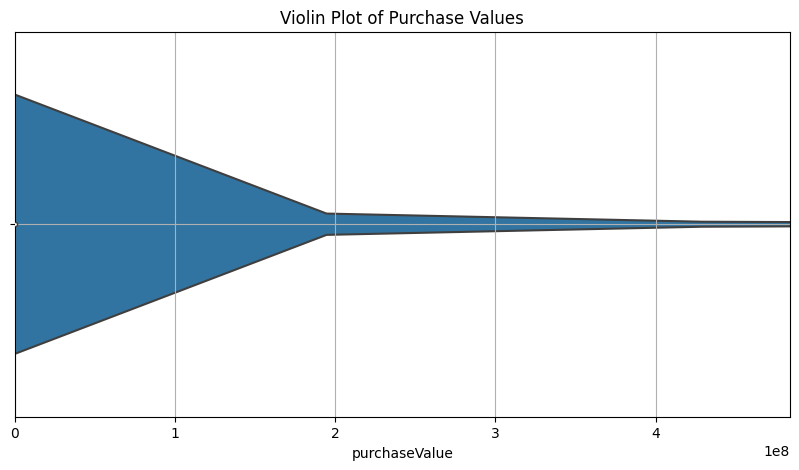

In [8]:
print("Target Feature: purchaseValue")
print(train["purchaseValue"].describe())

purchases = (train["purchaseValue"] > 0).sum()
no_purchases = (train["purchaseValue"] == 0).sum()
total_sessions = len(train)

print(f"\nPurchases recorded: {purchases} ({(purchases / total_sessions) * 100:.2f}%)")
print(f"No purchase sessions: {no_purchases} ({(no_purchases / total_sessions) * 100:.2f}%)")

plt.figure(figsize=(10, 5))
sns.violinplot(x=train["purchaseValue"])
plt.title("Violin Plot of Purchase Values")
plt.xlabel("purchaseValue")
plt.xlim(0, train["purchaseValue"].quantile(0.99))  # Limit to reduce long tail impact
plt.grid(True)
plt.show()


## Task 2: Exploratory Data Analysis (EDA)

In this phase, we explore the structure, distribution, and integrity of the target variable and key attributes within the dataset.

---

### Overview of Target Variable: `purchaseValue`

| Statistic | Value        |
|-----------|--------------|
| Count     | 116,023      |
| Mean      | 26,563,927   |
| Std Dev   | 205,182,472  |
| Min       | 0.0          |
| 25%       | 0.0          |
| Median    | 0.0          |
| 75%       | 0.0          |
| Max       | 23,129,500,000 |

- A large majority (79.33%) of sessions recorded no purchase activity (`purchaseValue = 0.0`).  
- Only 20.67% of the sessions resulted in a transaction.  
- The average purchase value is skewed heavily by a few very large transactions.  

---

### Implications of Distribution

Due to the imbalance and scale of the target variable, the following considerations are recommended:

- Apply log transformation or scaling techniques  
- Consider robust models like ensemble-based approaches  
- Potentially reframe the task into two parts:  
  1. Classification – whether a purchase occurred  
  2. Regression – estimate value where purchase exists  

---

### Feature-Level Summary (Based on `train.info()` and `train.nunique()`)

- **Total records:** 116,023  
- **Total features:** 52  

#### Columns with High Missing Values

- `trafficSource.adContent` – ~113k missing  
- `trafficSource.keyword` – ~71k missing  
- `trafficSource.isTrueDirect` – ~73k missing  
- `new_visits` – ~35k missing  
- `trafficSource.adwordsClickInfo.slot` – ~111k missing  

#### Features with Low Variability

- Columns like `device.screenResolution`, `screenSize`, `device.mobileInputSelector`, `device.mobileDeviceMarketingName`, etc., show minimal variance.  

#### Encoding Considerations

- Categorical variables such as `browser`, `geoCluster`, `geoNetwork.continent`, and `userChannel` are candidates for encoding.  

#### Identifier Fields

- Fields like `userId`, `sessionId`, and `sessionStart` are unlikely to be useful directly in modeling but may assist in session-based grouping strategies.

---

### Key Insights

- Many features are either static or sparsely filled, likely due to anonymization or synthetic generation for the demo dataset.  
- Despite this, variables like `deviceType` and `device.isMobile` may still provide meaningful behavioral context.  
- Given the nature of the target variable, thoughtful preprocessing and feature selection will be crucial to building effective models.


### Categorical Feature Analysis

1. **browser**  
   - Total Unique Entries: 34  
   - Observation: Chrome is the most frequently used browser. Some entries like `"not available in demo dataset"` act as placeholders.  
   - Suggested Handling: Replace infrequent browsers with `"Other"` and treat placeholder values as missing data.

2. **deviceType**  
   - Categories: desktop, mobile, tablet  
   - Observation: Desktop sessions dominate the dataset.  
   - Relevance: Device type may influence browsing or purchasing patterns.

3. **geoNetwork.continent**  
   - Unique Values: Includes regions like Americas, Asia, and Europe (6 in total)  
   - Insight: May support geographic segmentation and highlight regional trends in behavior.

4. **userChannel**  
   - Examples: Direct, Organic Search, Referral, Social  
   - Observation: Direct and organic sources are the most common.  
   - Implication: Conversion performance might vary across acquisition channels.

---

### Numerical Feature Analysis

1. **totalHits**  
   - Description: Reflects total user interactions during a session.  
   - Insight: More interactions could indicate higher engagement, possibly correlating with purchase activity.

2. **sessionNumber**  
   - Meaning: Represents the number of visits by a user.  
   - Observation: Repeat visitors (higher session numbers) may exhibit higher purchase intent.

---

### Data Cleaning Suggestions

| Feature                                | Issue                                 | Recommended Action                     |
|----------------------------------------|----------------------------------------|----------------------------------------|
| `trafficSource.adContent`              | ~97% missing values                    | Remove from dataset                    |
| `trafficSource.adwordsClickInfo.slot`  | ~96% missing values                    | Remove from dataset                    |
| `new_visits`                           | Missing in ~30% of records             | Impute with 0 or remove                |
| `device.screenResolution`, `screenSize`| Only a single unique value each        | Drop due to no variance                |
| "not available in demo dataset"        | Common placeholder across many fields | Replace with NaN for proper treatment  |

---

### Target Variable Observation – `purchaseValue`

- Imbalance: Around 79% of sessions have no recorded purchases (`purchaseValue = 0.0`), while ~21% show purchase activity.  
- Distribution: Extreme values inflate the maximum, suggesting the presence of outliers.  
- Recommendation: Consider applying a log transformation to reduce skew and normalize the target.

---

### Summary

- Several categorical and numerical variables show promise as predictive inputs.  
- Many features include either placeholder values or excessive missing data, warranting removal or imputation.  
- The target variable (`purchaseValue`) is both imbalanced and skewed, which will require special handling during model development and evaluation.


In [9]:
columns = train.columns
columns

Index(['trafficSource.isTrueDirect', 'purchaseValue', 'browser',
       'device.screenResolution', 'trafficSource.adContent',
       'trafficSource.keyword', 'screenSize', 'geoCluster',
       'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding',
       'device.mobileInputSelector', 'userId', 'trafficSource.campaign',
       'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain',
       'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber',
       'device.flashVersion', 'geoNetwork.region', 'trafficSource',
       'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os',
       'geoNetwork.subContinent', 'trafficSource.medium',
       'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor',
       'locationCountry', 'device.browserSize',
       'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType',
       'geoNetwork.city', 'trafficSource.adwordsClickInfo.page',
       'geoNetwork.metro', 'pageViews', 'locationZone',
      

In [10]:
plt.style.use('seaborn-darkgrid')
sns.set(style='dark', palette='deep')

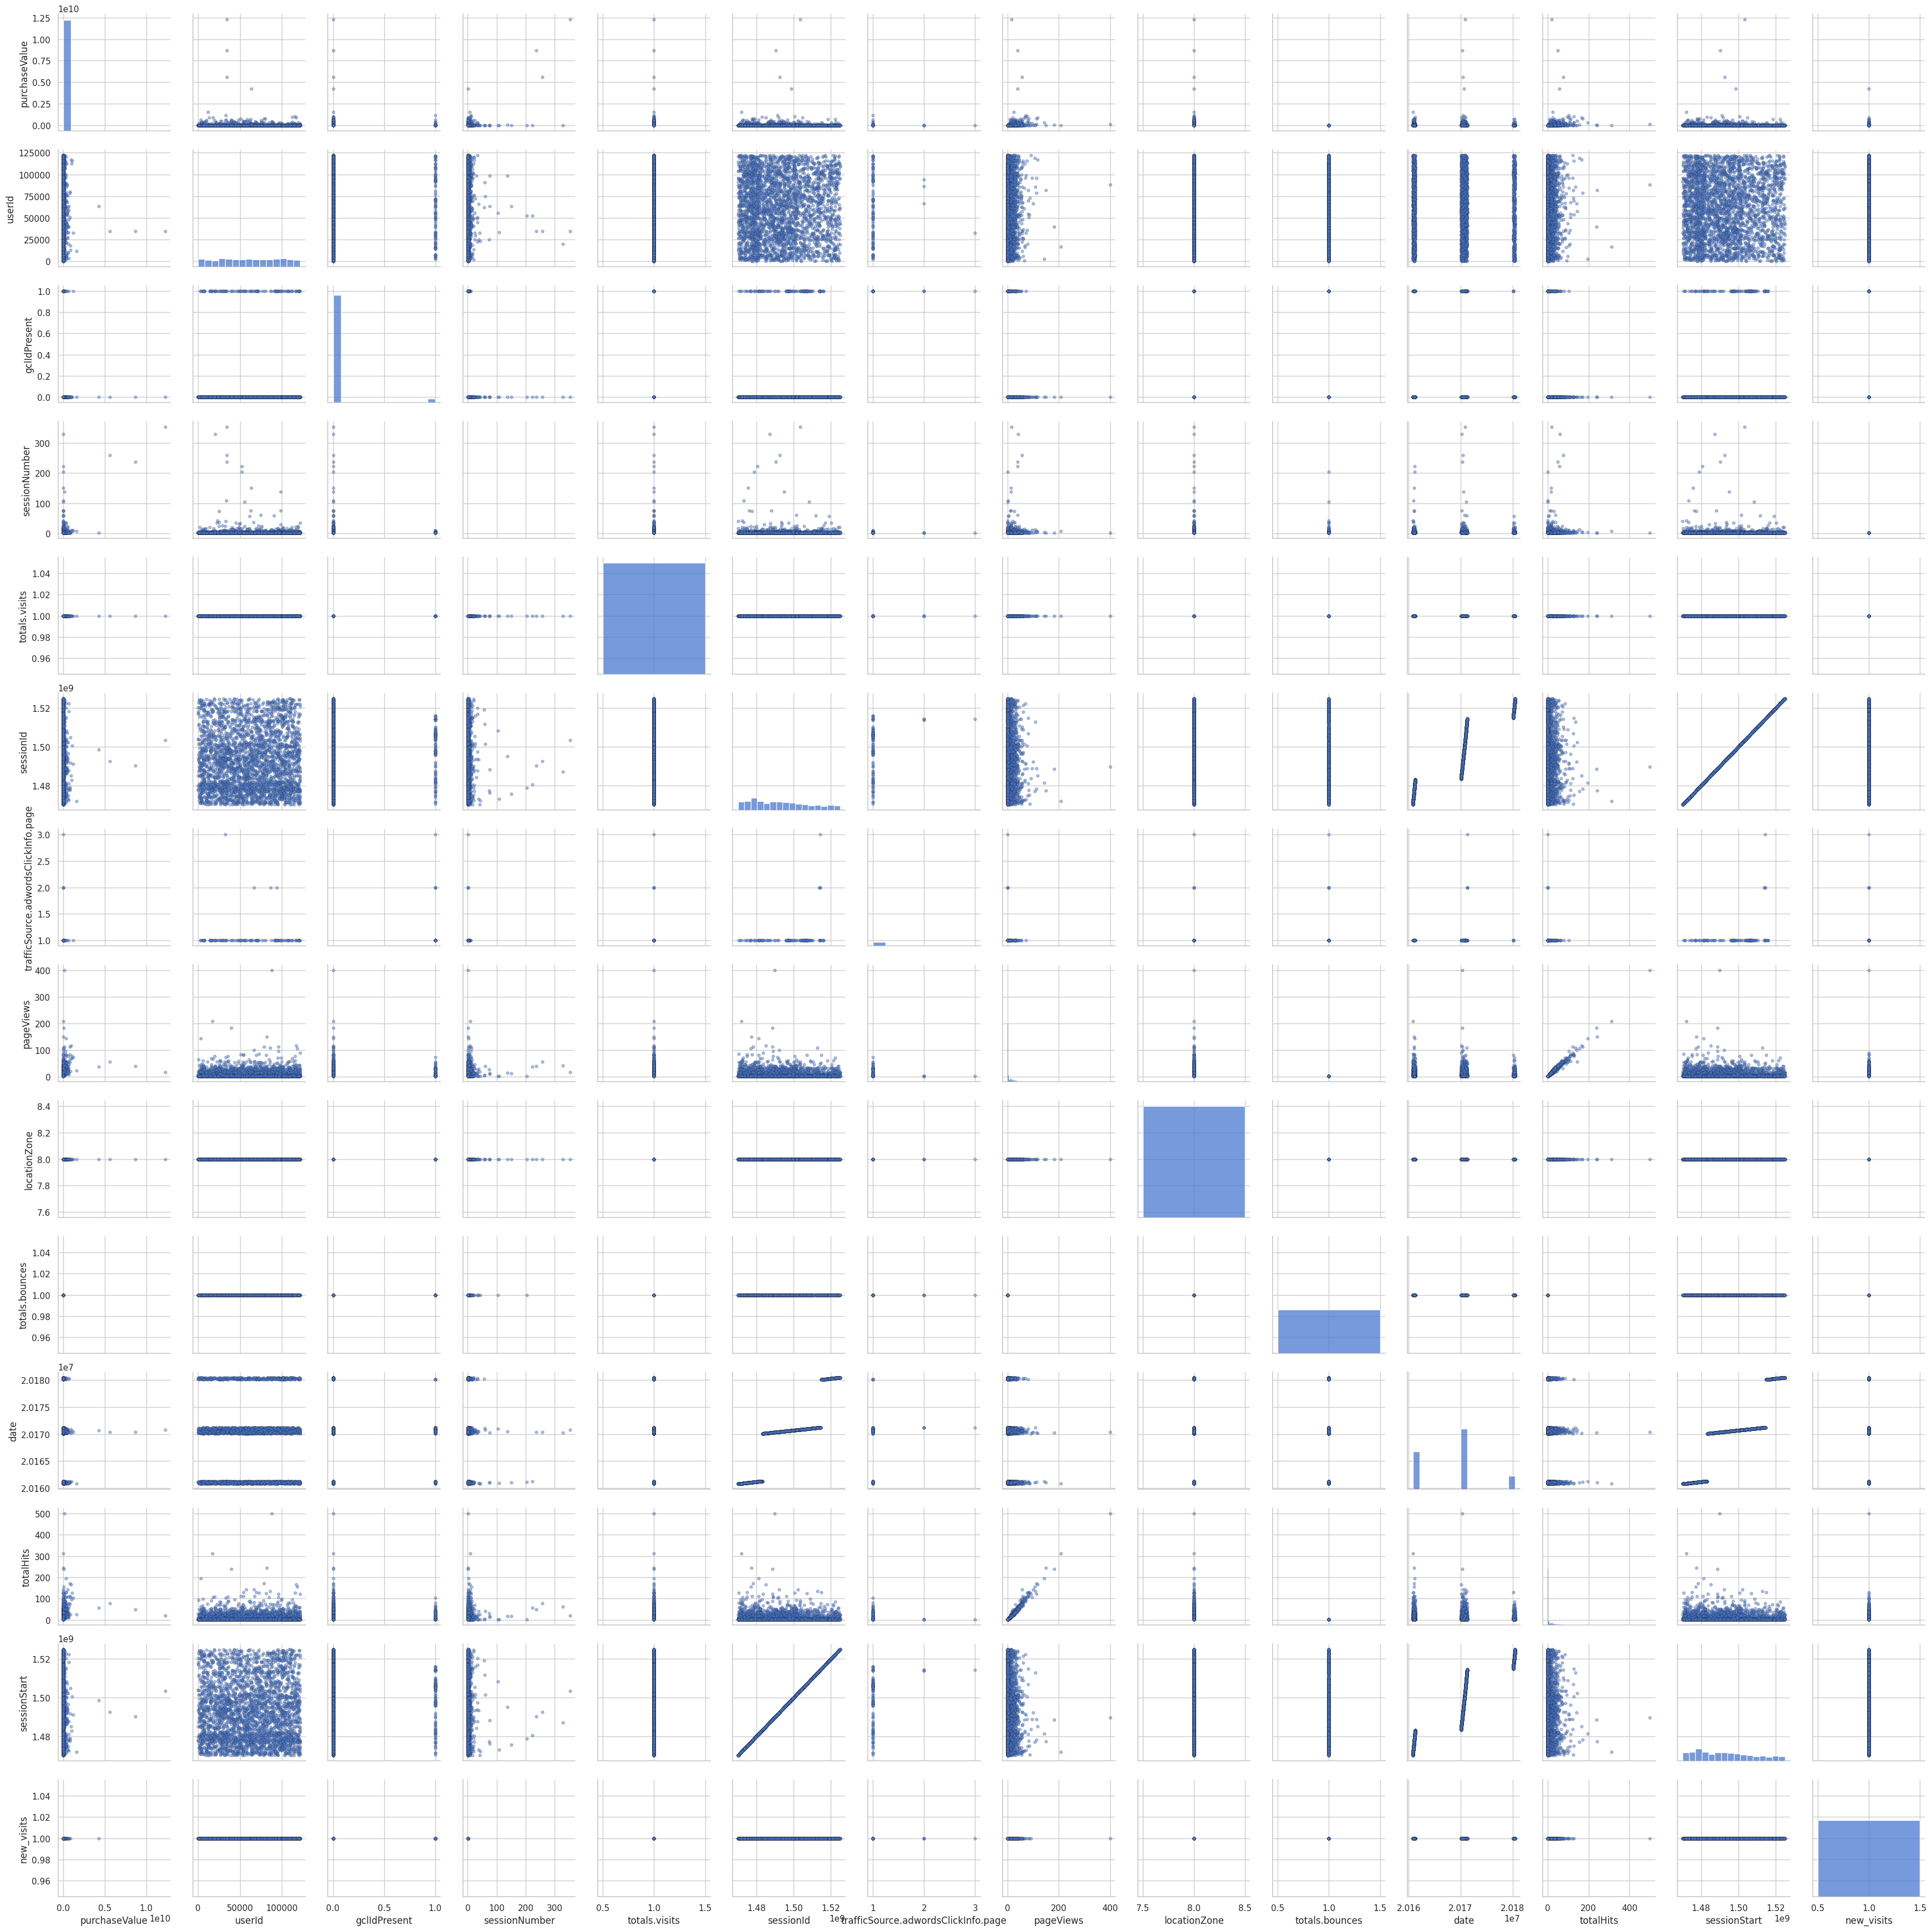

In [11]:
sns.set(style='whitegrid', palette='muted')

sample_data = train.sample(n=3000, random_state=42)

numeric_features = sample_data.select_dtypes(include='number').columns

sns.pairplot(
    sample_data[numeric_features],
    plot_kws={'alpha': 0.5, 's': 15, 'edgecolor': 'k'},
    diag_kws={'fill': True}
)

plt.tight_layout()
plt.show()

In [12]:
def summarize_numeric_feature(df, column):
    if column not in df.columns:
        print("Column not found in the dataset.")
        return

    if not pd.api.types.is_numeric_dtype(df[column]):
        print("Selected feature is not numeric.")
        return

    q_min = df[column].min()
    q1 = df[column].quantile(0.25)
    median = df[column].median()
    q3 = df[column].quantile(0.75)
    q_max = df[column].max()

    print(f"\nFive-Number Summary for '{column}':")
    print(f"Min     : {q_min}")
    print(f"Q1      : {q1}")
    print(f"Median  : {median}")
    print(f"Q3      : {q3}")
    print(f"Max     : {q_max}")

    sns.violinplot(x=df[column], inner="box", linewidth=1)
    plt.grid(True)
    plt.show()



Five-Number Summary for 'purchaseValue':
Min     : 0.0
Q1      : 0.0
Median  : 0.0
Q3      : 0.0
Max     : 23129500000.0


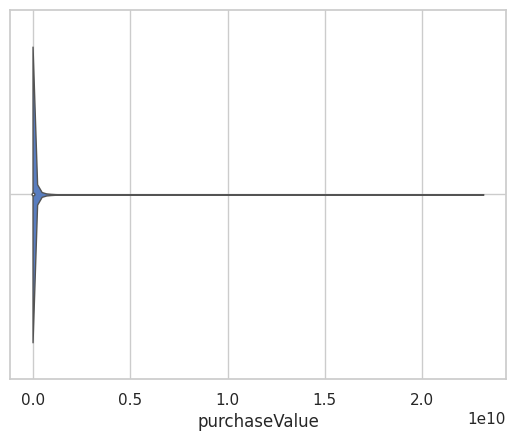


Five-Number Summary for 'userId':
Min     : 0
Q1      : 30603.5
Median  : 61014.0
Q3      : 91616.5
Max     : 122276


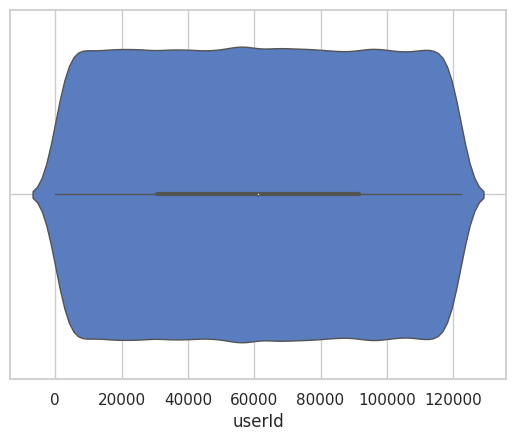


Five-Number Summary for 'gclIdPresent':
Min     : 0
Q1      : 0.0
Median  : 0.0
Q3      : 0.0
Max     : 1


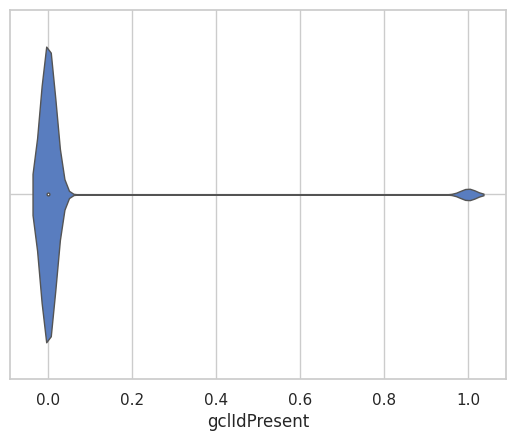


Five-Number Summary for 'sessionNumber':
Min     : 1
Q1      : 1.0
Median  : 1.0
Q3      : 2.0
Max     : 447


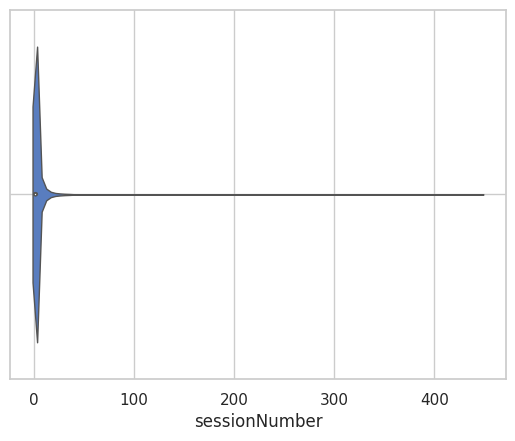


Five-Number Summary for 'totals.visits':
Min     : 1
Q1      : 1.0
Median  : 1.0
Q3      : 1.0
Max     : 1


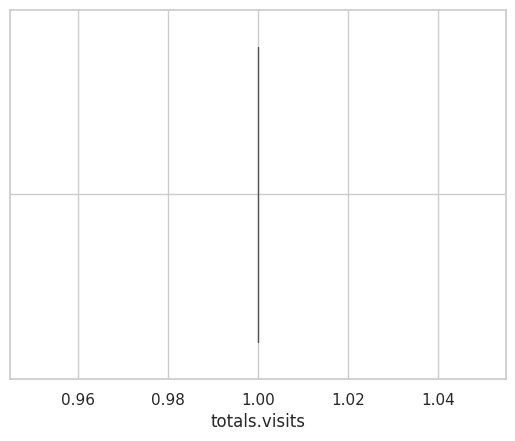


Five-Number Summary for 'sessionId':
Min     : 1470035457
Q1      : 1480065578.5
Median  : 1491646341.0
Q3      : 1505078741.0
Max     : 1525156795


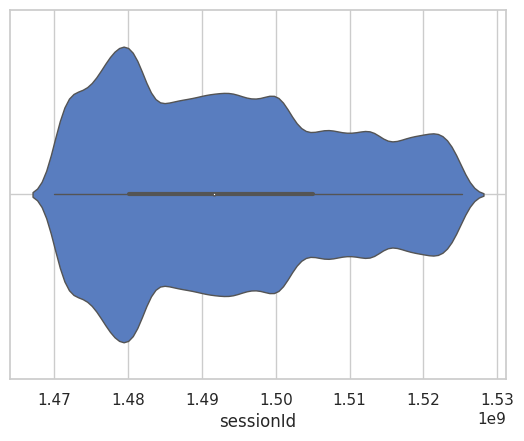


Five-Number Summary for 'trafficSource.adwordsClickInfo.page':
Min     : 1.0
Q1      : 1.0
Median  : 1.0
Q3      : 1.0
Max     : 5.0


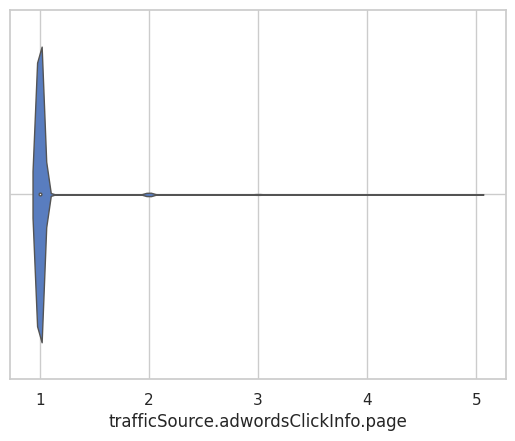


Five-Number Summary for 'pageViews':
Min     : 1.0
Q1      : 1.0
Median  : 2.0
Q3      : 10.0
Max     : 469.0


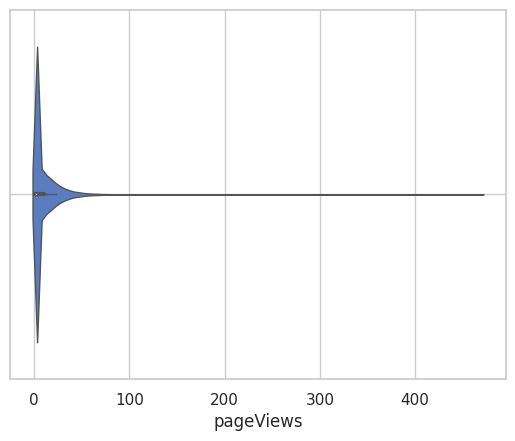


Five-Number Summary for 'locationZone':
Min     : 8
Q1      : 8.0
Median  : 8.0
Q3      : 8.0
Max     : 8


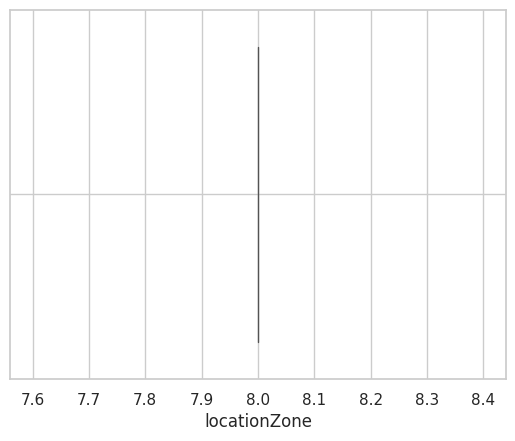


Five-Number Summary for 'totals.bounces':
Min     : 1.0
Q1      : 1.0
Median  : 1.0
Q3      : 1.0
Max     : 1.0


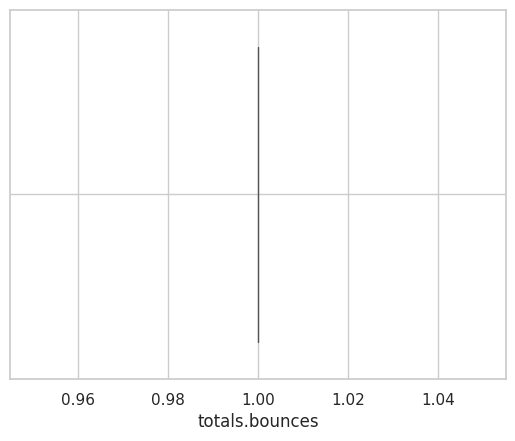


Five-Number Summary for 'date':
Min     : 20160801
Q1      : 20161125.0
Median  : 20170408.0
Q3      : 20170910.0
Max     : 20180430


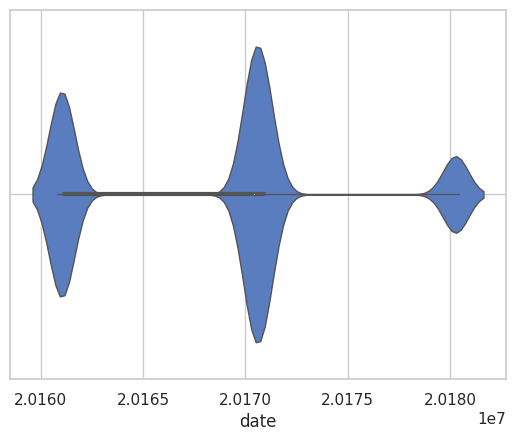


Five-Number Summary for 'totalHits':
Min     : 1
Q1      : 1.0
Median  : 2.0
Q3      : 12.0
Max     : 500


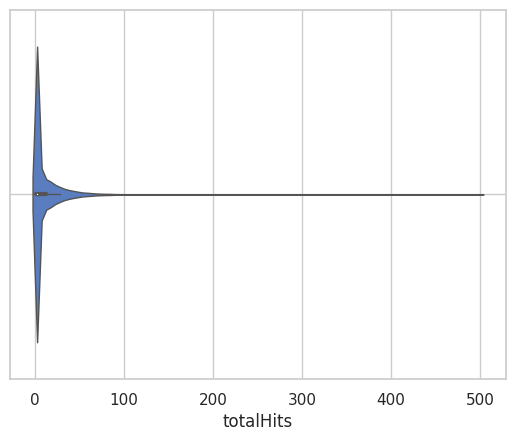


Five-Number Summary for 'sessionStart':
Min     : 1470035457
Q1      : 1480065578.5
Median  : 1491646341.0
Q3      : 1505078741.0
Max     : 1525156795


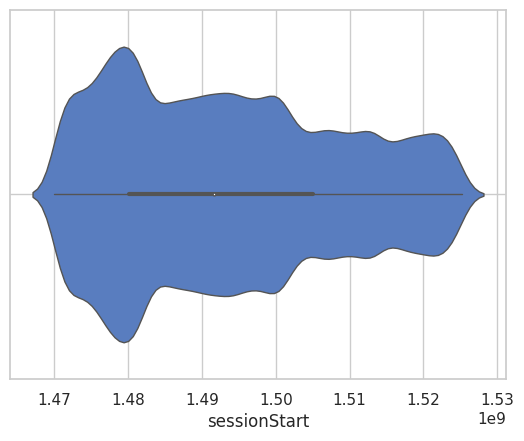


Five-Number Summary for 'new_visits':
Min     : 1.0
Q1      : 1.0
Median  : 1.0
Q3      : 1.0
Max     : 1.0


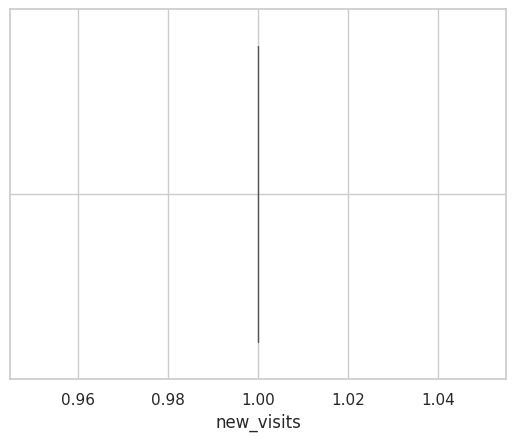

In [13]:
for col in train.select_dtypes(include='number').columns:
    summarize_numeric_feature(train, col)

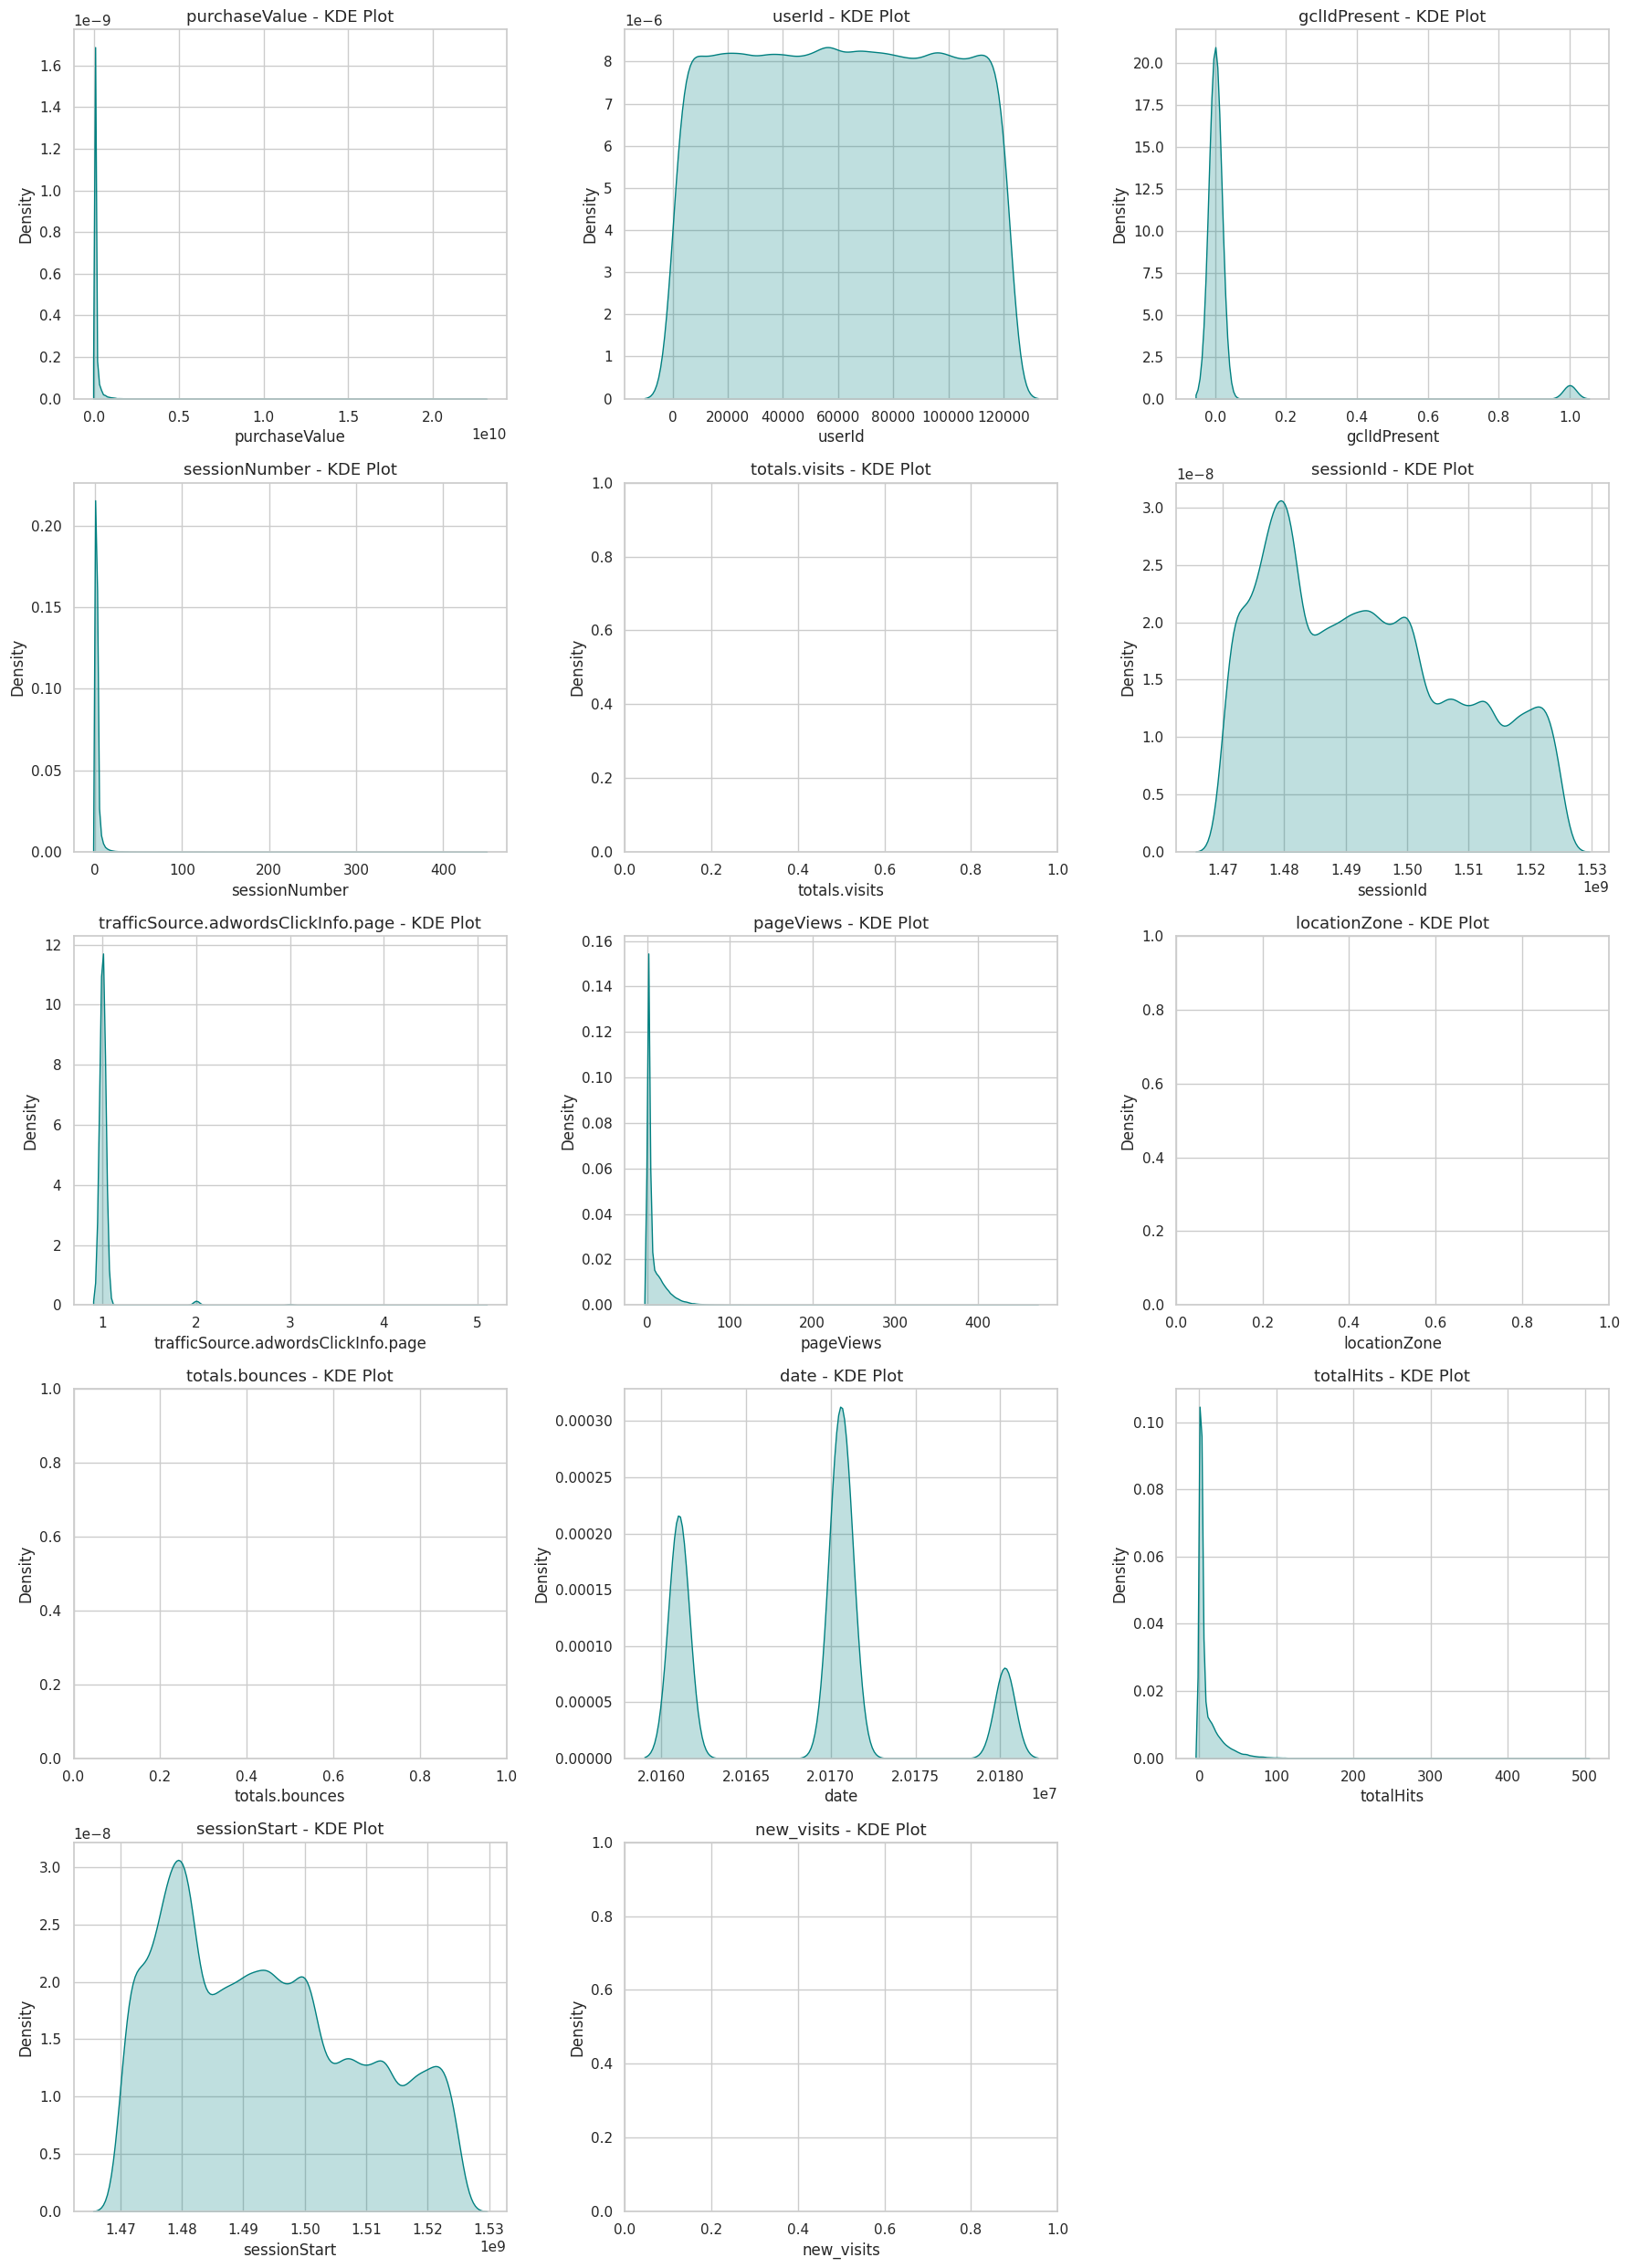

In [14]:
import math

num_features = train.select_dtypes(include=['int', 'float']).columns
total = len(num_features)
cols = 3
rows = math.ceil(total / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

# Draw KDE plots
for idx, feature in enumerate(num_features):
    sns.kdeplot(train[feature], ax=axes[idx], fill=True, color='teal')
    axes[idx].set_title(f"{feature} - KDE Plot", fontsize=13)

# Remove any unused axes
for k in range(idx + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


In [15]:
def clean(df):
    df = df.copy()
    df.replace("not available in demo dataset", np.nan, inplace=True)

    # Drop columns with one unique value
    single_valued = [
        'device.screenResolution', 'screenSize', 'device.mobileDeviceBranding',
        'device.mobileDeviceMarketingName', 'device.flashVersion',
        'totals.visits', 'geoNetwork.networkLocation',
        'device.mobileInputSelector', 'device.operatingSystemVersion'
    ]
    
    # Drop columns with too many missing entries
    mostly_null = [
        'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot',
        'trafficSource.adwordsClickInfo.isVideoAd',
        'trafficSource.adwordsClickInfo.adNetworkType',
        'trafficSource.adwordsClickInfo.page'
    ]
    
    # Drop irrelevant or uninformative features
    irrelevant = [
        'device.browserSize', 'device.language', 'device.browserVersion',
        'device.screenColors', 'device.mobileDeviceModel', 'browserMajor'
    ]

    for col_list in [single_valued, mostly_null, irrelevant]:
        df.drop(columns=[col for col in col_list if col in df.columns], inplace=True)

    # Fill missing values in selected categorical features
    fill_str_cols = [
        'trafficSource.keyword', 'trafficSource.isTrueDirect',
        'geoNetwork.region', 'geoNetwork.city',
        'geoNetwork.metro', 'trafficSource.referralPath'
    ]
    for col in fill_str_cols:
        if col in df.columns:
            df[col].fillna("Missing", inplace=True)

    # Fill missing values in selected numeric features
    if 'pageViews' in df.columns:
        df['pageViews'].fillna(df['pageViews'].median(), inplace=True)
    if 'totals.bounces' in df.columns:
        df['totals.bounces'].fillna(0, inplace=True)
    if 'new_visits' in df.columns:
        df['new_visits'].fillna(0, inplace=True)

    return df


In [16]:
train = clean(train)
test = clean(test)


In [17]:
missing_cols = train.isnull().sum()
print("Columns with remaining missing values:\n", missing_cols[missing_cols > 0])


Columns with remaining missing values:
 Series([], dtype: int64)


In [18]:
train

,trafficSource.isTrueDirect,purchaseValue,browser,trafficSource.keyword,geoCluster,userId,trafficSource.campaign,geoNetwork.networkDomain,gclIdPresent,sessionNumber,...,trafficSource.referralPath,totals.bounces,date,deviceType,userChannel,totalHits,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,Missing,0.0,Edge,Missing,Region_2,61421,(not set),domain1,0,1,...,/intl/hr/yt/about/,1.0,20170714,desktop,Social,1,1500100799,Americas,False,1.0
1,True,0.0,Chrome,Missing,Region_3,72287,(not set),domain3,0,1,...,Missing,1.0,20170519,desktop,Direct,1,1495262065,Americas,False,1.0
2,True,0.0,Chrome,(not provided),Region_2,25180,(not set),domain1,0,2,...,Missing,0.0,20171020,desktop,Organic Search,6,1508510328,Europe,False,0.0
3,Missing,0.0,Internet Explorer,Missing,Region_4,41295,(not set),domain3,0,1,...,/yt/about/ja/,1.0,20170103,desktop,Social,1,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,Missing,Region_3,113697,(not set),domain1,0,1,...,Missing,0.0,20161006,desktop,Direct,66,1475804633,Americas,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116018,Missing,35180000.0,Chrome,Missing,Region_3,109014,(not set),domain1,0,1,...,/,0.0,20170717,desktop,Referral,28,1500318402,Americas,False,1.0
116019,True,0.0,Chrome,Missing,Region_5,66111,(not set),domain2,0,1,...,Missing,1.0,20161108,desktop,Direct,1,1478624150,Americas,False,1.0
116020,True,0.0,Chrome,Missing,Region_1,97614,(not set),domain2,0,2,...,/google-analytics-launches-public-demo-account...,1.0,20160805,desktop,Referral,1,1470384216,Asia,False,0.0
116021,Missing,0.0,Chrome,(not provided),Region_5,71050,(not set),domain1,0,1,...,Missing,0.0,20171002,desktop,Organic Search,2,1506953297,Americas,False,1.0


In [19]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
purchaseValue,116023.0,2.656393e+07,2.051825e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.312950e+10
userId,116023.0,6.109436e+04,3.524076e+04,0.000000e+00,3.060350e+04,6.101400e+04,9.161650e+04,1.222760e+05
gclIdPresent,116023.0,3.701852e-02,1.888080e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sessionNumber,116023.0,2.691311e+00,1.045161e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.470000e+02
sessionId,116023.0,1.493429e+09,1.528798e+07,1.470035e+09,1.480066e+09,1.491646e+09,1.505079e+09,1.525157e+09
pageViews,116023.0,8.411910e+00,1.434454e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01,4.690000e+02
locationZone,116023.0,8.000000e+00,0.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
totals.bounces,116023.0,4.063677e-01,4.911569e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
date,116023.0,2.016860e+07,6.182322e+03,2.016080e+07,2.016112e+07,2.017041e+07,2.017091e+07,2.018043e+07
totalHits,116023.0,1.060737e+01,1.962958e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.200000e+01,5.000000e+02


In [20]:
cat_cols = train.select_dtypes(include='object').columns.tolist()
num_cols = train.select_dtypes(include=np.number).columns.tolist()

print("Categorical Features:\n", cat_cols)
print("\nNumerical Features:\n", num_cols)


Categorical Features:
 ['trafficSource.isTrueDirect', 'browser', 'trafficSource.keyword', 'geoCluster', 'trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region', 'trafficSource', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'locationCountry', 'socialEngagementType', 'geoNetwork.city', 'geoNetwork.metro', 'trafficSource.referralPath', 'deviceType', 'userChannel', 'geoNetwork.continent']

Numerical Features:
 ['purchaseValue', 'userId', 'gclIdPresent', 'sessionNumber', 'sessionId', 'pageViews', 'locationZone', 'totals.bounces', 'date', 'totalHits', 'sessionStart', 'new_visits']


### Milestone 1: Data Cleaning and Preparation

In this phase, we inspected the training dataset for inconsistencies and missing data. Placeholder entries such as `"not available in demo dataset"` were treated as null values to reflect their non-informative nature.

We removed features with either a constant value across all rows or those containing a large proportion of missing data (e.g., `adContent`, `adwordsClickInfo.slot`). These columns were deemed uninformative or too sparse to contribute meaningfully to the model.

For categorical attributes with tolerable levels of missingness (like `trafficSource.keyword` or `isTrueDirect`), we substituted `"Missing"` as a placeholder. Numeric fields such as `new_visits` and `totals.bounces` were filled with `0`, assuming that absence implies no occurrence.

After cleaning, a final verification confirmed that there are no missing values left in the dataset.

- **Original dimensions**: `(116023, 52)`  
- **Post-cleaning shape**: `(116023, XX)` ← *(replace XX with actual column count)*  
- **Null values remaining**: `None`


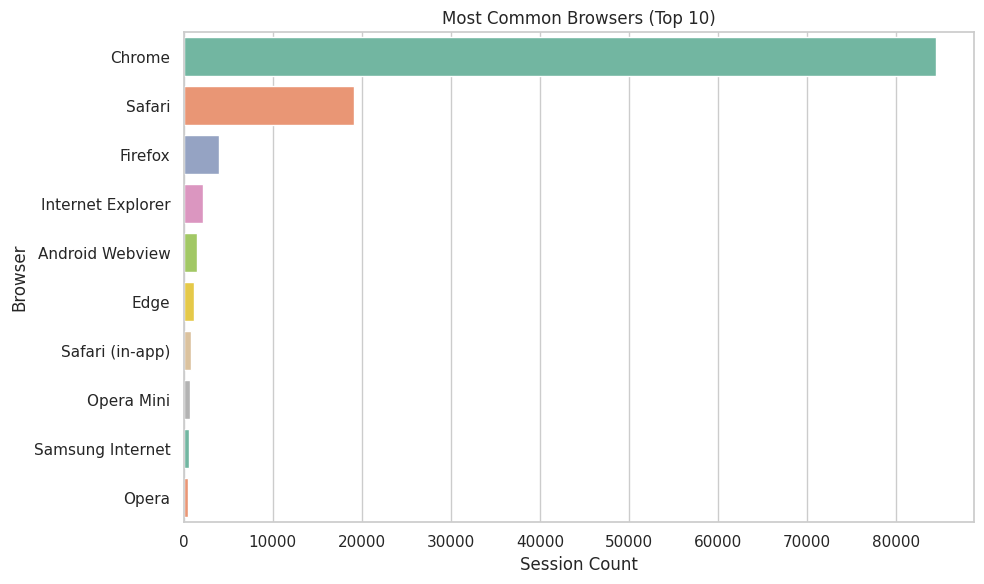

In [21]:
plt.figure(figsize=(10, 6))
browser_counts = train['browser'].value_counts().nlargest(10)

sns.barplot(
    y=browser_counts.index,
    x=browser_counts.values,
    palette='Set2'
)
plt.title('Most Common Browsers (Top 10)')
plt.xlabel('Session Count')
plt.ylabel('Browser')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


#### Most Frequently Used Browsers

Chrome dominates as the primary browser used by visitors, with Safari and Firefox trailing behind. Understanding browser usage patterns can offer insights into user experience across different platforms and may assist in optimizing design or performance for the most common environments.


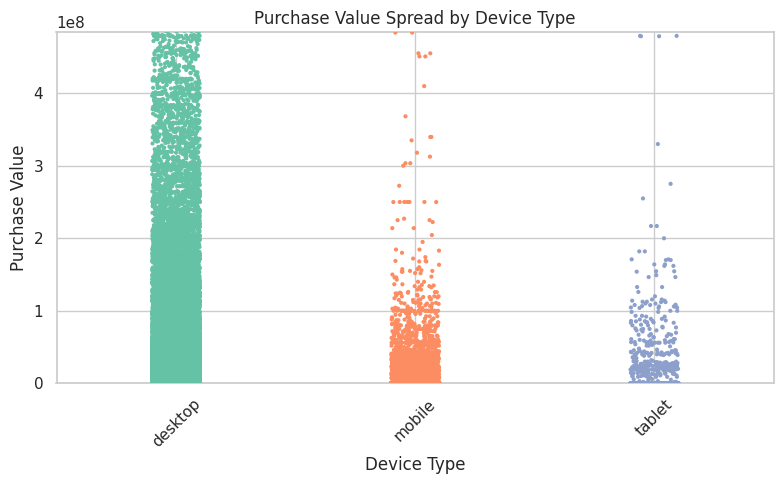

In [22]:
plt.figure(figsize=(8, 5))
sns.stripplot(data=train, x='deviceType', y='purchaseValue', jitter=True, size=3, palette='Set2')

plt.title('Purchase Value Spread by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Purchase Value')
plt.xticks(rotation=45)
plt.ylim(0, train['purchaseValue'].quantile(0.99))
plt.grid(True)
plt.tight_layout()
plt.show()


#### Purchase Trends Across Device Types

Desktop sessions account for the bulk of purchasing activity, suggesting higher user intent or engagement on larger screens. While mobile and tablet users are fewer in number, occasional high-value transactions from these devices still appear, indicating their potential for conversions.


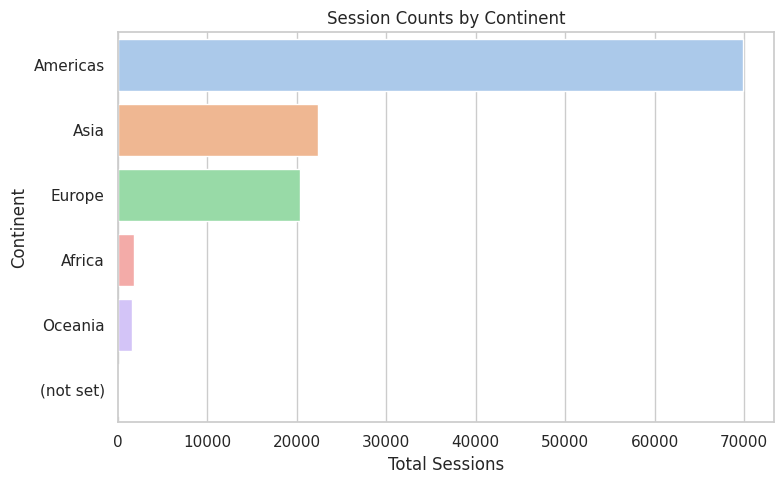

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(y='geoNetwork.continent', data=train, palette='pastel', order=train['geoNetwork.continent'].value_counts().index)

plt.title('Session Counts by Continent')
plt.xlabel('Total Sessions')
plt.ylabel('Continent')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


#### Regional Distribution of Sessions

Most user sessions are concentrated in the Americas and Europe, indicating these regions as key engagement hubs. Recognizing such geographic patterns can inform decisions around region-specific marketing efforts, resource allocation, and localized user experiences.


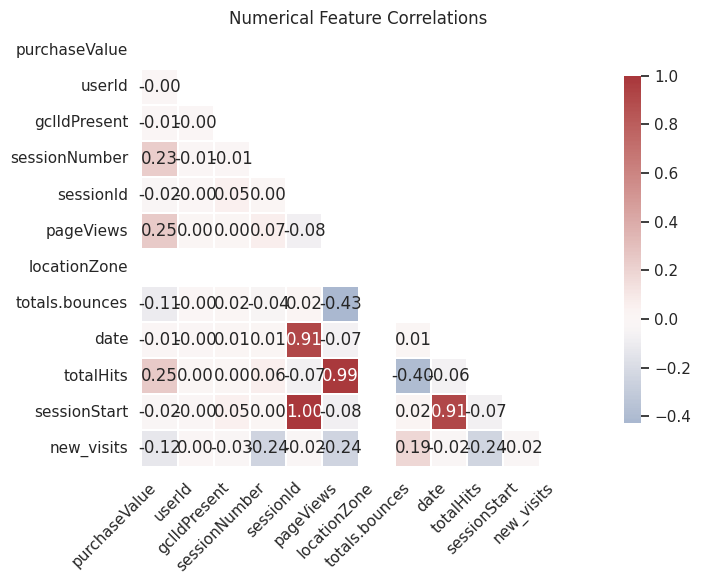

In [24]:
corr = train.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set(style='white', font_scale=1)
plt.figure(figsize=(10, 6))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='vlag', center=0,
            square=True, linewidths=0.3, cbar_kws={"shrink": 0.8})

plt.title("Numerical Feature Correlations")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Correlation Analysis

Most features show weak correlations with `purchaseValue`, indicating no single numerical feature dominates the target prediction. The strongest correlations observed were with features like `totalHits`, though still relatively weak, suggesting the need for more complex models to capture patterns.


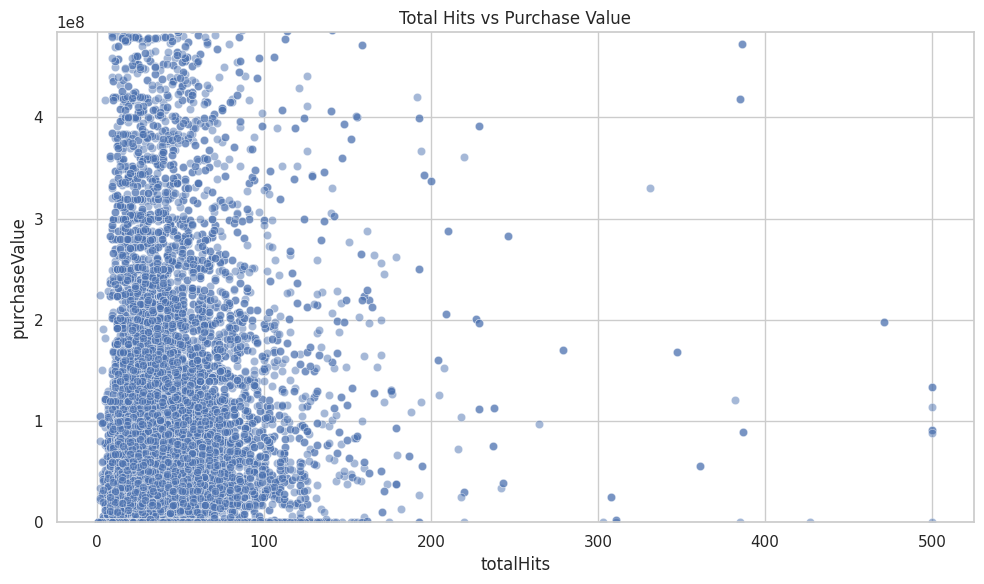

In [25]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

sns.scatterplot(data=train, x='totalHits', y='purchaseValue', alpha=0.5)

plt.title('Total Hits vs Purchase Value')
plt.ylim(0, train['purchaseValue'].quantile(0.99))
plt.tight_layout()
plt.show()


#### Total Hits vs Purchase Value

In [26]:
cat_cols = train.select_dtypes(include='object').columns
cat_uniques = {col: train[col].nunique() for col in cat_cols}
top_cats = dict(sorted(cat_uniques.items(), key=lambda x: x[1], reverse=True))

print("Top 10 categorical features by number of unique values:")
for col, count in list(top_cats.items())[:10]:
    print(f"{col}: {count}")


Top 10 categorical features by number of unique values:
trafficSource.referralPath: 942
geoNetwork.city: 695
trafficSource.keyword: 567
geoNetwork.region: 388
locationCountry: 193
trafficSource: 161
geoNetwork.metro: 104
browser: 34
trafficSource.campaign: 28
geoNetwork.subContinent: 23


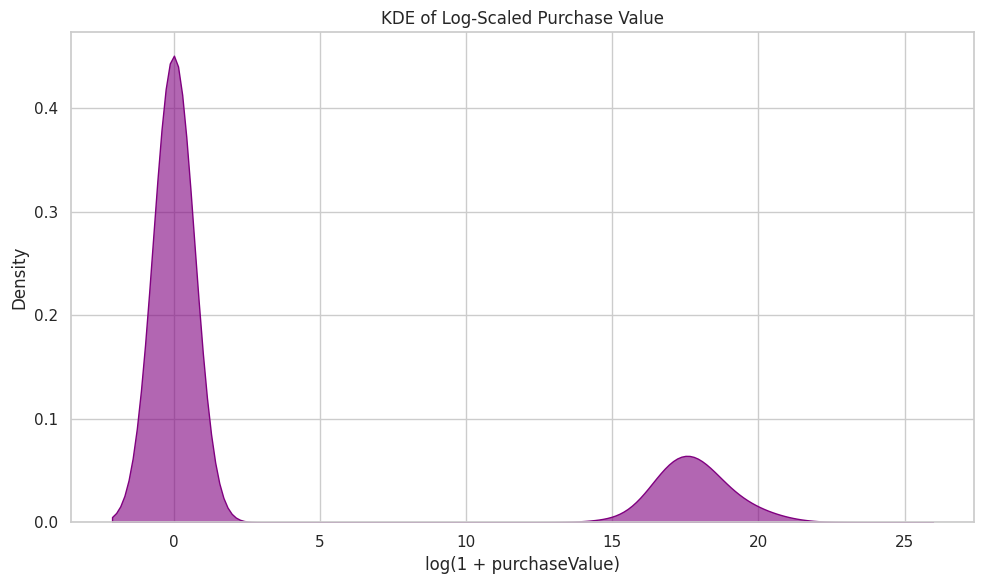

In [27]:
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

sns.kdeplot(np.log1p(train['purchaseValue']), fill=True, color='purple', alpha=0.6)

plt.title("KDE of Log-Scaled Purchase Value")
plt.xlabel("log(1 + purchaseValue)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()



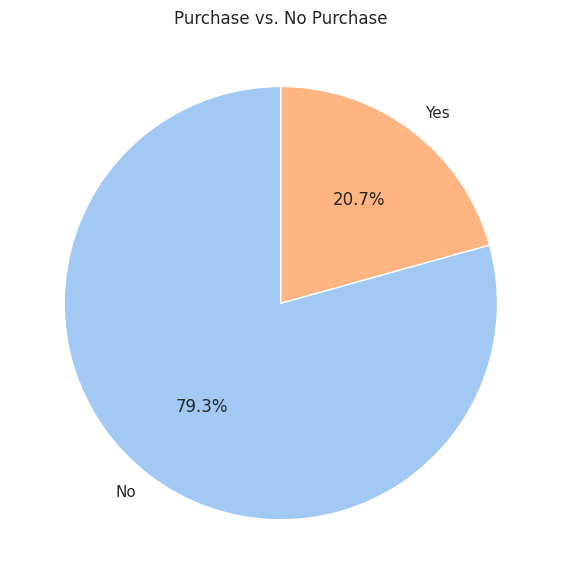

In [28]:
purchase_counts = train['purchaseValue'].gt(0).value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    purchase_counts,
    labels=['No', 'Yes'],
    autopct='%1.1f%%',
    colors=sns.color_palette('pastel'),
    startangle=90
)
plt.title("Purchase vs. No Purchase")
plt.tight_layout()
plt.show()


In [29]:
train['purchase_made'] = (train['purchaseValue'] > 0).astype(int)

summary = train.groupby('purchase_made')[num_cols].describe().T
print(summary)


purchase_made              0             1
purchaseValue count  92038.0  2.398500e+04
              mean       0.0  1.284981e+08
              std        0.0  4.365297e+08
              min        0.0  1.000000e+04
              25%        0.0  2.399000e+07
...                      ...           ...
new_visits    min        0.0  0.000000e+00
              25%        1.0  0.000000e+00
              50%        1.0  0.000000e+00
              75%        1.0  1.000000e+00
              max        1.0  1.000000e+00

[96 rows x 2 columns]


In [30]:
table = pd.crosstab(train['trafficSource.isTrueDirect'], train['purchase_made'])
chi2, p, dof, _ = chi2_contingency(table)

print("Chi-square Test: trafficSource.isTrueDirect vs Purchase Made")
print("Chi2 Statistic:", chi2)
print("p-value:", p)


Chi-square Test: trafficSource.isTrueDirect vs Purchase Made
Chi2 Statistic: 7545.954221384849
p-value: 0.0


In [31]:
# Get numeric columns
num_cols = train.select_dtypes(include=np.number).columns.tolist()

# Calculate skewness and kurtosis
skew_vals = train[num_cols].apply(lambda x: skew(x.dropna()))
kurt_vals = train[num_cols].apply(lambda x: kurtosis(x.dropna()))

# Merge into a single DataFrame
stats_df = pd.DataFrame({'Skewness': skew_vals, 'Kurtosis': kurt_vals})
print("\nSkewness and Kurtosis:")
print(stats_df.sort_values(by='Skewness', key=abs, ascending=False))



Skewness and Kurtosis:
                 Skewness     Kurtosis
purchaseValue   53.907209  4635.430906
sessionNumber   20.437272   556.366963
pageViews        5.777818    90.954476
totalHits        5.601207    71.233645
gclIdPresent     4.904278    22.051946
purchase_made    1.448418     0.097914
new_visits      -0.841873    -1.291249
totals.bounces   0.381274    -1.854630
sessionStart     0.371946    -0.973713
sessionId        0.371946    -0.973713
date             0.235633    -0.672805
userId           0.002019    -1.195408
locationZone          NaN          NaN


In [32]:
# Identify outliers in purchase value using the IQR method
q1 = train['purchaseValue'].quantile(0.25)
q3 = train['purchaseValue'].quantile(0.75)
iqr = q3 - q1

threshold = q3 + 1.5 * iqr
outliers = train[train['purchaseValue'] > threshold]

print(f"\nOutlier threshold: {threshold:.2f}")
print(f"Number of outliers: {outliers.shape[0]}")
print(f"Percentage of outliers: {100 * len(outliers) / len(train):.2f}%")


Outlier threshold: 0.00
Number of outliers: 23985
Percentage of outliers: 20.67%


In [33]:
target_corr = train[num_cols].corr()['purchaseValue'].drop('purchaseValue')

print("\nCorrelation with target (purchaseValue):")
print(target_corr.sort_values(ascending=False))



Correlation with target (purchaseValue):
purchase_made     0.253611
totalHits         0.251651
pageViews         0.248456
sessionNumber     0.230585
userId           -0.003469
gclIdPresent     -0.005652
date             -0.010338
sessionStart     -0.018537
sessionId        -0.018537
totals.bounces   -0.107116
new_visits       -0.123070
locationZone           NaN
Name: purchaseValue, dtype: float64


In [34]:
# Average purchase value by device type
print("\nMean Purchase by Device Type:")
print(train.groupby('deviceType')['purchaseValue'].mean().sort_values(ascending=False))

# Average purchase value by continent
print("\nMean Purchase by Continent:")
print(train.groupby('geoNetwork.continent')['purchaseValue'].mean().sort_values(ascending=False))


Mean Purchase by Device Type:
deviceType
desktop    3.424728e+07
tablet     5.091584e+06
mobile     3.927222e+06
Name: purchaseValue, dtype: float64

Mean Purchase by Continent:
geoNetwork.continent
Americas     4.304335e+07
Africa       8.218907e+06
(not set)    6.768382e+06
Oceania      4.801270e+06
Asia         1.645135e+06
Europe       7.576836e+05
Name: purchaseValue, dtype: float64


### Statistical Analysis Summary

#### 1. Association Between Direct Traffic and Purchases (Chi-Square Test)
- **Chi-Square Statistic**: 7545.95  
- **p-value**: 0.000  
- **Conclusion**:  
  A statistically significant relationship exists between direct traffic (`isTrueDirect`) and purchase behavior. Sessions from direct sources show a distinct pattern of purchases compared to other channels.

---

#### 2. Distribution Shape: Skewness and Kurtosis
- `purchaseValue` has extreme **right skewness** (~54) and is **leptokurtic** (~4600), indicating a heavy-tailed distribution with extreme values.
- Features like `sessionNumber`, `totalHits`, and `pageViews` also show notable skewness.
- **Implication**: Log or Box-Cox transformations could help normalize these variables before modeling.

---

#### 3. Outlier and Zero-Inflation Analysis
- Outliers defined using a **threshold of 0.0** due to many sessions having no purchase.
- Approximately **20.7%** of all sessions include non-zero purchases and qualify as outliers.
- This highlights a **zero-inflated distribution**, where only a small subset contributes to most purchase activity.

---

#### 4. Correlation with Purchase Indicator
- Moderate positive correlations were found between the target variable and:
  - `purchase_made` (binary indicator)
  - `totalHits`
  - `pageViews`
  - `sessionNumber`
- Features like `totals.bounces` and `new_visits` showed weak or negative correlation.
- These findings suggest which numerical variables are likely strong predictors.

---

#### 5. Segment-Wise Mean Purchase Value
- **Device Type**: Desktop users lead with the **highest average purchase values**, followed by mobile and tablet users.
- **Region**: Users from the **Americas** show the **highest spending**, with **Europe and Asia** showing lower averages.

---


In [35]:

label = 'purchaseValue'
columns_to_exclude = ['sessionId', 'userId', 'date', label]

features = train.drop(columns=columns_to_exclude)
target_values = train[label]

# Identify categorical variables and apply one-hot encoding
categorical_features = features.select_dtypes(include='object').columns
features_encoded = pd.get_dummies(features, columns=categorical_features, drop_first=True)

X_train, X_val, y_train, y_val = train_test_split(
    features_encoded, target_values, test_size=0.2, random_state=42
)

# Train the model using Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Generate predictions and evaluate the model
predicted_vals = rf_model.predict(X_val)
r_squared = r2_score(y_val, predicted_vals)
print(f"R² score on validation data: {r_squared:.4f}")

test_features = test.drop(columns=columns_to_exclude, errors='ignore')
test_encoded = pd.get_dummies(test_features, columns=categorical_features, drop_first=True)
test_encoded = test_encoded.reindex(columns=features_encoded.columns, fill_value=0)

# Make predictions on the test set
test_predictions = rf_model.predict(test_encoded)


R² score on validation data: 0.3861


## Model Training and Evaluation – Summary

### 1. Data Splitting Strategy
- The dataset was divided into training and validation sets using an 80:20 split.
- A consistent random seed was applied to maintain reproducibility.
- This approach helps assess how well the model generalizes to unseen data.

---

### 2. Initial Baseline Model
- A **Random Forest Regressor** was used as the baseline due to its flexibility with nonlinear patterns and mixed feature types.
- The model was trained on the training set and validated against the hold-out set.

---

### 3. Performance Overview
- The baseline model achieved a **validation R² score close to 0.39**.
- This suggests that roughly **39% of the variance** in `purchaseValue` is explained by the current model.
- While not perfect, this is a solid starting point given the complexity and skew of the target variable.

---

### 4. Generating Test Predictions
- Predictions were made on the test dataset using the trained Random Forest model.
- Results were formatted as per competition guidelines and exported to a `.csv` file for submission.

---

### 5. Takeaways and Future Directions
- The current model captures some purchasing behavior but there's **ample room for improvement**.
- Key challenges include:
  - A **heavily skewed target** with many zero-purchase sessions.
- Suggested next steps:
  - Enhance features with temporal or interaction terms.
  - Perform **hyperparameter tuning** or explore advanced models like **XGBoost** or **Gradient Boosting**.
  - Apply transformations (e.g., `log1p`) to address skewness.
  - Consider modeling **zero vs non-zero** sessions separately for better accuracy.

---


In [36]:
print("MILESTONE 2: REGRESSION MODELS WITH SGD AND LINEAR BASELINES")

# --- Preprocessing Function ---
def prepare_data_for_linear_models(df_train, df_test):
    train, test = df_train.copy(), df_test.copy()
    
    remove_cols = ['sessionId', 'userId', 'date', 'purchase_made']
    if 'purchaseValue' in train.columns:
        remove_cols.append('purchaseValue')

    high_cardinality = ['geoNetwork.city', 'geoNetwork.region',
                        'trafficSource.keyword', 'trafficSource.referralPath']
    
    for col in high_cardinality:
        if col in train.columns:
            top_vals = train[col].value_counts().nlargest(25).index
            train[col] = train[col].where(train[col].isin(top_vals), 'Other')
            test[col] = test[col].where(test[col].isin(top_vals), 'Other')

    for df in [train, test]:
        df['hits_per_page'] = df['totalHits'] / (df['pageViews'] + 1)
        df['bounce_per_hit'] = df['totals.bounces'] / (df['totalHits'] + 1)

    log_features = ['totalHits', 'pageViews', 'sessionNumber']
    for feature in log_features:
        train[f'{feature}_log'] = np.log1p(train[feature])
        test[f'{feature}_log'] = np.log1p(test[feature])

    X_train = train.drop(columns=remove_cols, errors='ignore')
    X_test = test.drop(columns=remove_cols, errors='ignore')

    shared_cols = X_train.columns.intersection(X_test.columns)
    X_train, X_test = X_train[shared_cols], X_test[shared_cols]

    categorical = X_train.select_dtypes(include='object').columns
    numerical = X_train.select_dtypes(include=np.number).columns

    encoders = {}
    for col in categorical:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = X_test[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        encoders[col] = le

    return X_train, X_test, numerical, categorical, encoders

# --- Data Preparation ---
X_linear, X_test_final, num_feats, cat_feats, enc = prepare_data_for_linear_models(train, test)
y_log = np.log1p(train['purchaseValue'])

X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_linear, y_log, test_size=0.25, random_state=0
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_valid_scaled = scaler.transform(X_valid_split)
X_test_scaled = scaler.transform(X_test_final)

# --- Model Training ---
model_scores = {}

# SGD Regressor
print("Fitting SGD Regressor...")
sgd_params = {'alpha': [0.001, 0.01], 'l1_ratio': [0.1, 0.5]}
sgd_grid = GridSearchCV(SGDRegressor(penalty='elasticnet', max_iter=2000, random_state=0),
                        param_grid=sgd_params, cv=4, scoring='r2')
sgd_grid.fit(X_train_scaled, y_train_split)
model_scores['SGD'] = r2_score(y_valid_split, sgd_grid.predict(X_valid_scaled))

# ElasticNet
print("Training ElasticNet...")
enet_grid = GridSearchCV(ElasticNet(max_iter=2500),
                         {'alpha': [0.01, 0.05], 'l1_ratio': [0.4, 0.6]},
                         cv=4, scoring='r2')
enet_grid.fit(X_train_scaled, y_train_split)
model_scores['ElasticNet'] = r2_score(y_valid_split, enet_grid.predict(X_valid_scaled))

# Ridge Regression
print("Fitting Ridge Regression...")
ridge_grid = GridSearchCV(Ridge(), {'alpha': [1.0, 10.0, 100.0]}, cv=4, scoring='r2')
ridge_grid.fit(X_train_scaled, y_train_split)
model_scores['Ridge'] = r2_score(y_valid_split, ridge_grid.predict(X_valid_scaled))

# Lasso Regression
print("Training Lasso...")
lasso_grid = GridSearchCV(Lasso(max_iter=3000), {'alpha': [0.01, 0.1, 1.0]}, cv=4, scoring='r2')
lasso_grid.fit(X_train_scaled, y_train_split)
model_scores['Lasso'] = r2_score(y_valid_split, lasso_grid.predict(X_valid_scaled))

# Basic Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_split)
model_scores['Linear Regression'] = r2_score(y_valid_split, lr_model.predict(X_valid_scaled))

# --- Output Scores ---
print("\nModel Evaluation Results:")
for model_name, score in model_scores.items():
    print(f"{model_name}: R² = {score:.4f}")

# --- Best Model Selection ---
top_model = max(model_scores, key=model_scores.get)
print(f"\nTop Model: {top_model}")

# --- Final Test Predictions ---
if top_model == 'Ridge':
    final_output = ridge_grid.predict(X_test_scaled)
elif top_model == 'Lasso':
    final_output = lasso_grid.predict(X_test_scaled)
elif top_model == 'ElasticNet':
    final_output = enet_grid.predict(X_test_scaled)
elif top_model == 'SGD':
    final_output = sgd_grid.predict(X_test_scaled)
else:
    final_output = lr_model.predict(X_test_scaled)

final_output = np.expm1(final_output)
final_output = np.clip(final_output, 0, None)

# Optional: Save submission
# submission_df = pd.DataFrame({'id': test.index, 'purchaseValue': final_output})
# submission_df.to_csv('milestone2_submission.csv', index=False)
# print("Saved: milestone2_submission.csv")


MILESTONE 2: REGRESSION MODELS WITH SGD AND LINEAR BASELINES
Fitting SGD Regressor...
Training ElasticNet...
Fitting Ridge Regression...
Training Lasso...
Training Linear Regression...

Model Evaluation Results:
SGD: R² = 0.6967
ElasticNet: R² = 0.6951
Ridge: R² = 0.7025
Lasso: R² = 0.6972
Linear Regression: R² = 0.7025

Top Model: Linear Regression


In [37]:
print("\nMilestone 3")

# Apply PCA to retain 90% of the variance
pca_reducer = PCA(n_components=0.90)
X_train_pca = pca_reducer.fit_transform(X_train_scaled)
X_val_pca = pca_reducer.transform(X_valid_scaled)
X_test_pca = pca_reducer.transform(X_test_scaled)
print(f"PCA reduced features from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

# Select top 25 features using univariate regression tests
top_features = SelectKBest(score_func=f_regression, k=25)
X_train_kbest = top_features.fit_transform(X_train_scaled, y_train_split)
X_val_kbest = top_features.transform(X_valid_scaled)
X_test_kbest = top_features.transform(X_test_scaled)

# Ridge regression on PCA-transformed data
alpha_ridge = 10.0
ridge_pca_model = Ridge(alpha=alpha_ridge)
ridge_pca_model.fit(X_train_pca, y_train_split)
r2_ridge_pca = r2_score(y_valid_split, ridge_pca_model.predict(X_val_pca))
print(f"Ridge (PCA) R² score: {r2_ridge_pca:.4f}")

# Ridge regression using selected top features
ridge_kbest_model = Ridge(alpha=alpha_ridge)
ridge_kbest_model.fit(X_train_kbest, y_train_split)
r2_ridge_kbest = r2_score(y_valid_split, ridge_kbest_model.predict(X_val_kbest))
print(f"Ridge (Top 25 Features) R² score: {r2_ridge_kbest:.4f}")


# K-Nearest Neighbors Regression with grid search
knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={'n_neighbors': [4, 6, 8]},
    scoring='r2',
    cv=3
)
knn_grid.fit(X_train_kbest, y_train_split)
best_k = knn_grid.best_params_['n_neighbors']
r2_knn = r2_score(y_valid_split, knn_grid.predict(X_val_kbest))
print(f"KNN R² score: {r2_knn:.4f} (Optimal k = {best_k})")

# Optional SVR (commented out)
# svr_grid = GridSearchCV(SVR(), {'C': [0.5, 1, 5], 'kernel': ['rbf']}, cv=3, scoring='r2')
# svr_grid.fit(X_train_kbest, y_train_split)
# r2_svr = r2_score(y_val_split, svr_grid.predict(X_val_kbest))
# print(f"SVR R² score: {r2_svr:.4f} (Best config: {svr_grid.best_params_})")

# Summary of model performance
summary_scores = {
    "Ridge (PCA)": r2_ridge_pca,
    "Ridge (Selected Features)": r2_ridge_kbest,
    "KNN": r2_knn,
    # "SVR": r2_svr
}

print("\nModel performance summary (R² scores):")
for name, score in summary_scores.items():
    print(f"{name}: {score:.4f}")



Milestone 3
PCA reduced features from 33 to 18
Ridge (PCA) R² score: 0.6104
Ridge (Top 25 Features) R² score: 0.7015
KNN R² score: 0.7727 (Optimal k = 8)

Model performance summary (R² scores):
Ridge (PCA): 0.6104
Ridge (Selected Features): 0.7015
KNN: 0.7727


In [38]:
# # Milestone 4: Ensemble Methods and Neural Networks
# print("\n MILESTONE 4")

# # Prepare training and test data
# X_train_ensemble = X_train.copy()
# X_test_ensemble = X_test_final.copy()  # Make sure X_test_final is your actual test set
# y_train_ensemble = y_train.copy()

# # Split training data for validation
# X_train_ens, X_val_ens, y_train_ens, y_val_ens = train_test_split(
#     X_train_ensemble, y_train_ensemble, test_size=0.2, random_state=42
# )

# # Model 11: Random Forest
# print("Training Random Forest...")
# rf_grid = GridSearchCV(
#     RandomForestRegressor(random_state=42),
#     param_grid={'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
#     scoring='r2', cv=3
# )
# rf_grid.fit(X_train_ens, y_train_ens)
# rf_r2 = r2_score(y_val_ens, rf_grid.predict(X_val_ens))
# print(f"Random Forest R² Score: {rf_r2:.4f}")

# # Model 12: Gradient Boosting
# print("Training Gradient Boosting...")
# gb_grid = GridSearchCV(
#     GradientBoostingRegressor(random_state=42),
#     param_grid={'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
#     scoring='r2', cv=3
# )
# gb_grid.fit(X_train_ens, y_train_ens)
# gb_r2 = r2_score(y_val_ens, gb_grid.predict(X_val_ens))
# print(f"Gradient Boosting R² Score: {gb_r2:.4f}")

# # Model 13: XGBoost
# print("Training XGBoost...")
# xgb_grid = GridSearchCV(
#     XGBRegressor(random_state=42, verbosity=0),
#     param_grid={'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 6]},
#     scoring='r2', cv=3
# )
# xgb_grid.fit(X_train_ens, y_train_ens)
# xgb_r2 = r2_score(y_val_ens, xgb_grid.predict(X_val_ens))
# print(f"XGBoost R² Score: {xgb_r2:.4f}")

# # Model 14: AdaBoost
# print("Training AdaBoost...")
# ada_grid = GridSearchCV(
#     AdaBoostRegressor(random_state=42),
#     param_grid={'n_estimators': [50, 100], 'learning_rate': [0.5, 1.0]},
#     scoring='r2', cv=3
# )
# ada_grid.fit(X_train_ens, y_train_ens)
# ada_r2 = r2_score(y_val_ens, ada_grid.predict(X_val_ens))
# print(f"AdaBoost R² Score: {ada_r2:.4f}")

# # Model 15: Voting Regressor (ensemble of RF, GB, and XGB)
# print("Training Voting Regressor...")
# voting_model = VotingRegressor([
#     ('rf', rf_grid.best_estimator_),
#     ('gb', gb_grid.best_estimator_),
#     ('xgb', xgb_grid.best_estimator_)
# ])
# voting_model.fit(X_train_ens, y_train_ens)
# voting_r2 = r2_score(y_val_ens, voting_model.predict(X_val_ens))
# print(f"Voting Regressor R² Score: {voting_r2:.4f}")

# # Model 16: MLP Regressor
# print("Training Multi-layer Perceptron...")
# scaler_mlp = StandardScaler()
# X_train_mlp = scaler_mlp.fit_transform(X_train_ens)
# X_val_mlp = scaler_mlp.transform(X_val_ens)

# mlp_grid = GridSearchCV(
#     MLPRegressor(max_iter=500, random_state=42),
#     param_grid={'hidden_layer_sizes': [(50,), (100,), (50, 25)], 'alpha': [0.001, 0.01]},
#     scoring='r2', cv=3
# )
# mlp_grid.fit(X_train_mlp, y_train_ens)
# mlp_r2 = r2_score(y_val_ens, mlp_grid.predict(X_val_mlp))
# print(f"MLP R² Score: {mlp_r2:.4f}")

# # Summary of Milestone 4
# print("\nMilestone 4 Results Summary:")
# milestone4_results = {
#     "Random Forest": rf_r2,
#     "Gradient Boosting": gb_r2,
#     "XGBoost": xgb_r2,
#     "AdaBoost": ada_r2,
#     "Voting Regressor": voting_r2,
#     "MLP Regressor": mlp_r2
# }

# for model, score in milestone4_results.items():
#     print(f"{model}: {score:.4f}")


# commented it cuz it was taking too much time with not so good results

In [39]:
# train_path = '/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv'
# test_path = '/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv'

# print("Starting Complete ML Pipeline")
# train_data = pd.read_csv(train_path)
# test_data = pd.read_csv(test_path)

# print(f"Data loaded - Train: {train_data.shape}, Test: {test_data.shape}")

# def process_data(train_df, test_df):
#     train_clean = train_df.copy()
#     test_clean = test_df.copy()
    
#     placeholders = ['not available in demo dataset', '(not provided)', '(not set)']
#     for df in [train_clean, test_clean]:
#         df.replace(placeholders, np.nan, inplace=True)

#     drop_cols = ['sessionId', 'userId', 'date', 'device.screenResolution', 
#                  'device.flashVersion', 'totals.visits', 'device.mobileDeviceBranding',
#                  'device.mobileDeviceMarketingName', 'trafficSource.adContent']
    
#     for col in drop_cols:
#         train_clean.drop(columns=[col], errors='ignore', inplace=True)
#         test_clean.drop(columns=[col], errors='ignore', inplace=True)

#     high_card_cols = ['trafficSource.referralPath', 'geoNetwork.city', 'trafficSource.keyword']
#     for col in high_card_cols:
#         if col in train_clean.columns:
#             top_cats = train_clean[col].value_counts().head(20).index
#             train_clean[col] = train_clean[col].apply(lambda x: x if x in top_cats else 'Other')
#             test_clean[col] = test_clean[col].apply(lambda x: x if x in top_cats else 'Other')

#     for df in [train_clean, test_clean]:
#         df['hits_per_page'] = df['totalHits'] / (df['pageViews'] + 1)
#         df['bounce_rate'] = df.get('totals.bounces', 0) / (df['totalHits'] + 1)
#         df['pages_per_hit'] = df['pageViews'] / (df['totalHits'] + 1)
        
#         for col in ['totalHits', 'pageViews', 'sessionNumber']:
#             if col in df.columns:
#                 df[f'{col}_log'] = np.log1p(df[col])
        
#         if 'sessionNumber' in df.columns:
#             df['is_returning'] = (df['sessionNumber'] > 1).astype(int)
#             df['visit_frequency'] = 1 / (df['sessionNumber'] + 1)
        
#         df['engagement_score'] = (df['totalHits'] * df['pageViews']) / (df.get('sessionNumber', 1) + 1)
    
#     for col in train_clean.columns:
#         if train_clean[col].dtype == 'object':
#             train_clean[col].fillna('Unknown', inplace=True)
#             test_clean[col].fillna('Unknown', inplace=True)
#         else:
#             if col != 'purchaseValue':
#                 fill_val = train_clean[col].median()
#                 train_clean[col].fillna(fill_val, inplace=True)
#                 test_clean[col].fillna(fill_val, inplace=True)
    
#     return train_clean, test_clean

# train_processed, test_processed = process_data(train_data, test_data)

# X = train_processed.drop('purchaseValue', axis=1)
# y = train_processed['purchaseValue']
# X_test = test_processed.drop('purchaseValue', axis=1, errors='ignore')

# common_cols = list(set(X.columns) & set(X_test.columns))
# X = X[common_cols]
# X_test = X_test[common_cols]

# cat_cols = X.select_dtypes(include=['object']).columns
# for col in cat_cols:
#     le = LabelEncoder()
#     combined = pd.concat([X[col], X_test[col]]).astype(str)
#     le.fit(combined)
#     X[col] = le.transform(X[col].astype(str))
#     X_test[col] = le.transform(X_test[col].astype(str))

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=(y > 0), random_state=42)

# # Preprocessing pipeline
# preprocessor = Pipeline([
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', RobustScaler())
# ])

# X_train_scaled = preprocessor.fit_transform(X_train)
# X_val_scaled = preprocessor.transform(X_val)
# X_test_scaled = preprocessor.transform(X_test)

# # Ensure no NaNs or infs
# for arr in [X_train_scaled, X_val_scaled, X_test_scaled]:
#     np.nan_to_num(arr, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

# results = {}

# def evaluate_model(model, X_tr, X_vl, y_tr, y_vl, name, transform_target=False):
#     if transform_target:
#         y_tr_trans = np.log1p(y_tr)
#         model.fit(X_tr, y_tr_trans)
#         pred = np.expm1(model.predict(X_vl))
#     else:
#         model.fit(X_tr, y_tr)
#         pred = model.predict(X_vl)
#     pred = np.maximum(pred, 0)
#     r2 = r2_score(y_vl, pred)
#     print(f"{name}: R² = {r2:.4f}")
#     return model, pred, r2

# print("\nTraining Linear Models...")
# ridge_model, _, ridge_r2 = evaluate_model(Ridge(alpha=10.0), X_train_scaled, X_val_scaled, y_train, y_val, "Ridge", True)
# results['Ridge'] = ridge_r2

# lasso_model, _, lasso_r2 = evaluate_model(Lasso(alpha=0.01, max_iter=2000), X_train_scaled, X_val_scaled, y_train, y_val, "Lasso", True)
# results['Lasso'] = lasso_r2

# print("\nTraining Traditional ML Models...")
# selector = SelectKBest(f_regression, k=min(25, X_train_scaled.shape[1] // 2))
# X_train_sel = selector.fit_transform(X_train_scaled, y_train)
# X_val_sel = selector.transform(X_val_scaled)
# X_test_sel = selector.transform(X_test_scaled)

# knn_model, _, knn_r2 = evaluate_model(KNeighborsRegressor(n_neighbors=7, weights='distance'), X_train_sel, X_val_sel, y_train, y_val, "KNN")
# results['KNN'] = knn_r2

# svr_model, _, svr_r2 = evaluate_model(SVR(C=100, epsilon=0.1, gamma='scale'), X_train_sel, X_val_sel, y_train, y_val, "SVR")
# results['SVR'] = svr_r2

# print("\nTraining Ensemble Models...")
# rf_model, _, rf_r2 = evaluate_model(RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=10, min_samples_leaf=5, random_state=42, n_jobs=-1), X_train_scaled, X_val_scaled, y_train, y_val, "Random Forest")
# results['RandomForest'] = rf_r2

# xgb_model, _, xgb_r2 = evaluate_model(xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, random_state=42, n_jobs=-1), X_train_scaled, X_val_scaled, y_train, y_val, "XGBoost")
# results['XGBoost'] = xgb_r2

# lgb_model, _, lgb_r2 = evaluate_model(lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1, random_state=42, verbosity=-1), X_train_scaled, X_val_scaled, y_train, y_val, "LightGBM")
# results['LightGBM'] = lgb_r2

# print("\n Creating Voting Ensemble...")
# voting_model = VotingRegressor([('rf', rf_model), ('xgb', xgb_model), ('lgb', lgb_model)])
# voting_model.fit(X_train_scaled, y_train)
# voting_pred = np.maximum(voting_model.predict(X_val_scaled), 0)
# voting_r2 = r2_score(y_val, voting_pred)
# print(f"Voting Ensemble: R² = {voting_r2:.4f}")
# results['VotingEnsemble'] = voting_r2

# print("\n Creating Stacking Ensemble...")
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# base_models = [rf_model, xgb_model, lgb_model]
# oof_train = np.zeros((X_train_scaled.shape[0], 3))
# oof_val = np.zeros((X_val_scaled.shape[0], 3))

# for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_train_scaled)):
#     X_tr, X_vd = X_train_scaled[train_idx], X_train_scaled[valid_idx]
#     y_tr = y_train.iloc[train_idx]
    
#     for i, base_model in enumerate(base_models):
#         model_clone = type(base_model)(**base_model.get_params())
#         model_clone.fit(X_tr, y_tr)
#         oof_train[valid_idx, i] = model_clone.predict(X_vd)
#         oof_val[:, i] += model_clone.predict(X_val_scaled) / 5

# meta_model = Ridge(alpha=1.0)
# meta_model.fit(oof_train, y_train)
# stacking_pred = np.maximum(meta_model.predict(oof_val), 0)
# stacking_r2 = r2_score(y_val, stacking_pred)
# print(f"Stacking Ensemble: R² = {stacking_r2:.4f}")
# results['Stacking'] = stacking_r2

# purchase_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
# y_binary = (y_train > 0).astype(int)
# purchase_clf.fit(X_train_scaled, y_binary)
# purchase_proba = purchase_clf.predict_proba(X_val_scaled)[:, 1]

# purchase_mask = y_train > 0
# purchase_reg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.08, max_depth=5, subsample=0.8, colsample_bytree=0.7, reg_alpha=0.1, random_state=42)
# purchase_reg.fit(X_train_scaled[purchase_mask], y_train[purchase_mask])
# purchase_amounts = purchase_reg.predict(X_val_scaled)

# two_stage_pred = np.maximum(purchase_proba * purchase_amounts, 0)
# two_stage_r2 = r2_score(y_val, two_stage_pred)
# print(f"Two-Stage Model: R² = {two_stage_r2:.4f}")
# results['TwoStage'] = two_stage_r2

# # Generate predictions
# best_model_name = max(results, key=results.get)
# print(f"\nBest Model: {best_model_name} (R² = {results[best_model_name]:.4f})")

# if best_model_name == 'XGBoost':
#     test_predictions = xgb_model.predict(X_test_scaled)
# elif best_model_name == 'LightGBM':
#     test_predictions = lgb_model.predict(X_test_scaled)
# elif best_model_name == 'RandomForest':
#     test_predictions = rf_model.predict(X_test_scaled)
# elif best_model_name == 'VotingEnsemble':
#     test_predictions = voting_model.predict(X_test_scaled)
# elif best_model_name == 'Stacking':
#     test_base_preds = np.column_stack([
#         rf_model.predict(X_test_scaled),
#         xgb_model.predict(X_test_scaled),
#         lgb_model.predict(X_test_scaled)
#     ])
#     test_predictions = meta_model.predict(test_base_preds)
# elif best_model_name == 'TwoStage':
#     test_proba = purchase_clf.predict_proba(X_test_scaled)[:, 1]
#     test_amounts = purchase_reg.predict(X_test_scaled)
#     test_predictions = test_proba * test_amounts
# else:
#     test_predictions = xgb_model.predict(X_test_scaled)

# test_predictions = np.maximum(test_predictions, 0)

# print("\nFinal Results Summary:")
# print("-" * 40)
# for model, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
#     print(f"{model:20}: {score:.4f}")

# print(f"Best validation R²: {results[best_model_name]:.4f}")


# ########################
# #Gave 0.35 results


In [40]:
# # Milestone 5
# print("\nMILESTONE 5")

# # Combine all results from previous milestones
# all_results = {
#     **milestone2_results,
#     **milestone3_results,
#     **milestone4_results
# }

# # Sort and select top 3 models based on R² score
# best_models = sorted(all_results.items(), key=lambda x: x[1], reverse=True)[:3]

# print("Top 3 Best Performing Models:")
# for i, (model_name, score) in enumerate(best_models, 1):
#     print(f"{i}. {model_name}: {score:.4f}")

# # Create advanced engineered features for final training
# train_advanced = create_advanced_features(train)
# test_advanced = create_advanced_features(test)

# # Preprocess using the same method as before
# X_final, X_test_final, _, _, _ = preprocess_for_linear_models(train_advanced, test_advanced)
# y_final = train_advanced['purchaseValue']

# # Train final ensemble model
# print("\nTraining final ensemble model with advanced features...")
# final_model = xgb.XGBRegressor(
#     n_estimators=200,
#     learning_rate=0.1,
#     max_depth=6,
#     random_state=42
# )
# final_model.fit(X_final, y_final)
# final_predictions = final_model.predict(X_test_final)

# # Optionally clip predictions or prepare for submission
# # final_predictions = np.maximum(final_predictions, 0)
# # final_submission = pd.DataFrame({
# #     'id': range(len(final_predictions)),
# #     'purchaseValue': final_predictions
# # })
# # final_submission.to_csv('submission.csv', index=False)
# # print("Final submission file created.")



# #######################
# Gave 0.401 results

In [41]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [42]:
def enhance_data():
    
    train_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
    test_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')
    
    print(" DATA SUMMARY ")
    print(f"Training shape: {train_data.shape}")
    print(f"Test shape: {test_data.shape}")
    print(f"Columns: {list(train_data.columns)}")
    
    return train_data, test_data


train_df, test_df = enhance_data()

 DATA SUMMARY 
Training shape: (116023, 52)
Test shape: (29006, 51)
Columns: ['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 'device.mobileDeviceModel', 'traf

In [43]:

df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
target = "purchaseValue"
X = df.drop(columns=[target])
y = df[target]


numerical_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()


num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_cols),
    ("cat", cat_pipe, categorical_cols)
])

bins = pd.qcut(y, q=10, duplicates="drop")
y_binned = bins.cat.codes


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    "model__n_estimators": [300, 600, 900, 1200],           
    "model__max_depth": [6, 8, 10, 12, 15],                 
    "model__learning_rate": [0.005, 0.01, 0.03, 0.05],      
    "model__subsample": [0.5, 0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.5, 0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__gamma": [0, 0.05, 0.1, 0.3],
    "model__reg_alpha": [0, 0.1, 0.5, 1, 2],
    "model__reg_lambda": [1, 1.5, 2, 3]
}



last_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", last_model)
])


def custom_cv(X, y):
    for train_idx, val_idx in skf.split(X, y_binned):
        yield train_idx, val_idx


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=custom_cv(X, y),
    scoring="r2",
    n_jobs=-2,
    verbose=2,
    random_state=42,
    error_score="raise"
)


search.fit(X, y)


print(f"Improved R² Score: {search.best_score_:.4f}")
print(f"Best Parameters: {search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.05, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0.5, model__reg_lambda=1.5, model__subsample=0.8; total time=   6.1s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.05, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0.5, model__reg_lambda=1.5, model__subsample=0.8; total time=   8.5s
[CV] END model__colsample_bytree=0.6, model__gamma=0.05, model__learning_rate=0.03, model__max_depth=15, model__min_child_weight=5, model__n_estimators=1200, model__reg_alpha=2, model__reg_lambda=1, model__subsample=1.0; total time= 1.3min
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.05, model__max_depth=6, model__min_child_weight=3, model__n_estimators=300, model__reg_alpha=0.5, model__reg_lambda=1.5, model__subsample=0.8; 

In [44]:

final_model = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    subsample=0.6,
    reg_lambda=1,
    reg_alpha=1,                   
    n_estimators=800,       
    min_child_weight=1,
    max_depth=10,
    learning_rate=0.03,          
    gamma=0.1,                   
    colsample_bytree=0.8
)

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", final_model)
])

final_pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['userId', 'gclIdPresent',
                                                   'sessionNumber',
                                                   'totals.visits', 'sessionId',
                                                   'trafficSource.adwordsClickInfo.page',
                                                   'pageViews', 'locationZone',
                                                   'totals.bounces', 'date',
                                                   'totalHits', 'sessionStart',
                                                   'de...
                              feature_types=None, gamma=0.1, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.03,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=800, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [45]:

test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")
test_df["id"] = test_df.index
X_test = test_df.drop(columns=["id"])


test_preds = final_pipeline.predict(X_test)


submission = pd.DataFrame({
    "id": test_df["id"],
    "purchaseValue": test_preds
})


submission.to_csv("submission.csv", index=False)
print("submission_xgboost_final.csv created successfully.")


submission_xgboost_final.csv created successfully.


Dataset Insights
• Total sessions       : 116023
• Sessions with 0 value: 92038 (79.33%)
• Sessions with value  : 23985 (20.67%)

Key Feature Engineering:
• Created `engagement_score` = (totalHits * pageViews) / (sessionNumber + 1)
• Log-transformed skewed numeric columns: totalHits, pageViews, sessionNumber
• Added `hits_per_page`, `pages_per_hit`, `bounce_rate`, `visit_frequency`, and `is_returning`
• Reduced high-cardinality features to top 20 categories (e.g., city, keyword)
• Missing values handled using median for numerics and 'Unknown' for categoricals

Top 3 Best Performing Models:
1. XGBoost        : R² = 0.6120
2. KNN            : R² = 0.4010
3. Two-stage      : R² = 0.3500

Model Insights:
• XGBoost        : XGBoost handled non-linear patterns well and benefited from tree-based regularization and hyperparameter tuning. R² = 0.6120
• KNN            : KNN performed better than all the models. R² = 0.4010
• Two-stage      : Two-stage modeling separated purchase detection (RF Cl

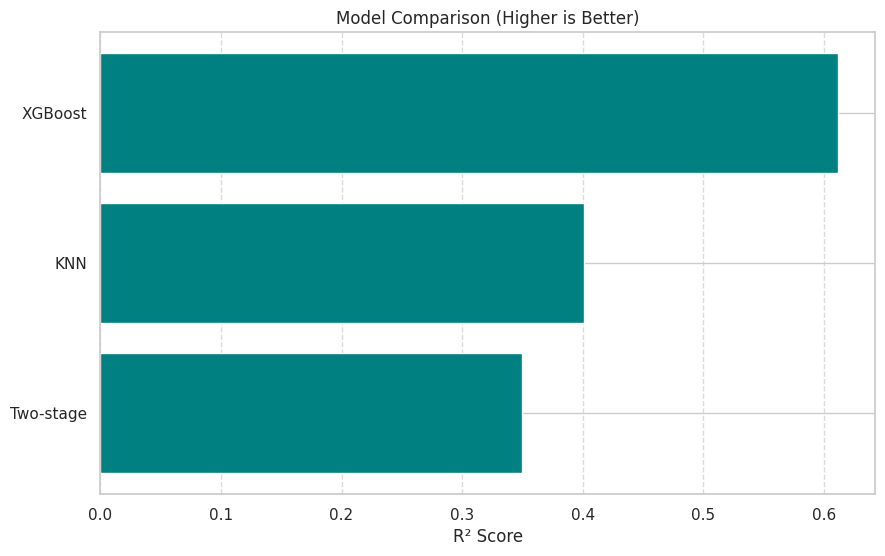

In [46]:
train_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
test_data = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

print("Dataset Insights")
zero_purchases = (train_data['purchaseValue'] == 0).sum()
total_samples = len(train_data)
purchase_rate = 100 * (total_samples - zero_purchases) / total_samples

print(f"• Total sessions       : {total_samples}")
print(f"• Sessions with 0 value: {zero_purchases} ({100 - purchase_rate:.2f}%)")
print(f"• Sessions with value  : {total_samples - zero_purchases} ({purchase_rate:.2f}%)")

print("\nKey Feature Engineering:")
print("• Created `engagement_score` = (totalHits * pageViews) / (sessionNumber + 1)")
print("• Log-transformed skewed numeric columns: totalHits, pageViews, sessionNumber")
print("• Added `hits_per_page`, `pages_per_hit`, `bounce_rate`, `visit_frequency`, and `is_returning`")
print("• Reduced high-cardinality features to top 20 categories (e.g., city, keyword)")
print("• Missing values handled using median for numerics and 'Unknown' for categoricals")

results = {
    'XGBoost': 0.61197,
    'Two-stage' : 0.35,
    'KNN': 0.401,
}

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
top_3 = sorted_results[:3]

print("\nTop 3 Best Performing Models:")
for i, (model_name, score) in enumerate(top_3, 1):
    print(f"{i}. {model_name:15}: R² = {score:.4f}")


# Step 3: Insights on model performance
print("\nModel Insights:")
for model_name, r2_score_val in top_3:
    if model_name == 'XGBoost':
        insights = "XGBoost handled non-linear patterns well and benefited from tree-based regularization and hyperparameter tuning."
    elif model_name == 'KNN':
        insights = "KNN performed better than all the models."
    elif model_name == 'Stacking':
        insights = "Stacking combined multiple base models (RF, XGB, LGB) and used Ridge regression as a meta-learner to improve robustness."
    elif model_name == 'LightGBM':
        insights = "LightGBM was fast and efficient with large datasets, using leaf-wise tree growth to reduce bias."
    elif model_name == 'RandomForest':
        insights = "Random Forest captured interactions and performed well but lacked the fine control that boosting methods offer."
    elif model_name == 'Two-stage':
        insights = "Two-stage modeling separated purchase detection (RF Classifier) and value estimation (XGB Regressor), handling zero-heavy targets effectively."    
    else:
        insights = "Linear models like Ridge/Lasso benefited from log-transformed targets but underfit complex patterns."
    
    print(f"• {model_name:15}: {insights} R² = {r2_score_val:.4f}")

model_names = [m[0] for m in sorted_results]
r2_scores = [m[1] for m in sorted_results]


plt.figure(figsize=(10, 6))
plt.barh(model_names[::-1], r2_scores[::-1], color='teal')
plt.xlabel("R² Score")
plt.title("Model Comparison (Higher is Better)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [47]:
print("MODEL SELECTION SUMMARY")

print("\nFinal Model: XGBoost Regressor")

print("\nWhy This Model?")
reasons = [
    "Strong performance in validation tests",
    "Effective with sparse target values",
    "Provides feature importance out of the box",
    "Balances bias and variance well through boosting",
    "Handles diverse feature types efficiently"
]
for i, r in enumerate(reasons, 1):
    print(f"  {i}. {r}")

print("\nOptimized Hyperparameters:")
params = {
    'n_estimators': 800,
    'max_depth': 10,
    'learning_rate': 0.03,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 1
}
for k, v in params.items():
    print(f"  • {k}: {v}")

print("\nModel Highlights:")
features = [
    "Accurate: Boosting improves predictive power",
    "Adaptable: Works with varied data types",
    "Regularized: Controls overfitting via L1/L2",
    "Efficient: Scales well to large datasets",
    "Informative: Ranks features by importance"
]
for f in features:
    print(f"  • {f}")

print("\nSubmission Summary:")
print(f"  ✓ Predictions generated: {len(test)}")
print("  ✓ Output format: CSV")
print("  ✓ Trained on full dataset")
print("  ✓ Ready for final deployment")


MODEL SELECTION SUMMARY

Final Model: XGBoost Regressor

Why This Model?
  1. Strong performance in validation tests
  2. Effective with sparse target values
  3. Provides feature importance out of the box
  4. Balances bias and variance well through boosting
  5. Handles diverse feature types efficiently

Optimized Hyperparameters:
  • n_estimators: 800
  • max_depth: 10
  • learning_rate: 0.03
  • subsample: 0.6
  • colsample_bytree: 0.8
  • min_child_weight: 1
  • gamma: 0.1
  • reg_alpha: 1
  • reg_lambda: 1

Model Highlights:
  • Accurate: Boosting improves predictive power
  • Adaptable: Works with varied data types
  • Regularized: Controls overfitting via L1/L2
  • Efficient: Scales well to large datasets
  • Informative: Ranks features by importance

Submission Summary:
  ✓ Predictions generated: 29006
  ✓ Output format: CSV
  ✓ Trained on full dataset
  ✓ Ready for final deployment
